# INTEGRATE Case Study example

This notebook contains an examples of the simplest use of INTEGRATE, on which tTEM data from various caswe study areas, will be be inverted using simple generic, resistivity only, prior models.


In [1]:
try:
    # Check if the code is running in an IPython kernel (which includes Jupyter notebooks)
    get_ipython()
    # If the above line doesn't raise an error, it means we are in a Jupyter environment
    # Execute the magic commands using IPython's run_line_magic function
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except:
    # If get_ipython() raises an error, we are not in a Jupyter environment
    # # # #%load_ext autoreload
    # # # #%autoreload 2
    pass

import integrate as ig
import numpy as np
import os
import matplotlib.pyplot as plt
hardcopy=True

## Download the data for a specific case study

The following case study areas are available: 

* DAUGAARD
* FANGEL
* HALD


In [16]:
case = 'DAUGAARD'
case = 'FANGEL'
#case = 'HALD'

files = ig.get_case_data(case=case)
f_data_h5 = files[0]
file_gex= ig.get_gex_file_from_data(f_data_h5)
# check that file_gex exists
if not os.path.isfile(file_gex):
    print("file_gex=%s does not exist in the current folder." % file_gex)

print('CASE: %s' % case)
print('Using hdf5 data file %s with gex file %s' % (f_data_h5,file_gex))

Getting data for case: FANGEL
Downloaded FANGEL_AVG.h5
Downloaded TX07_20230828_2x4_RC20-33.gex
File README_FANGEL already exists and is identical. Skipping download.
CASE: FANGEL
Using hdf5 data file FANGEL_AVG.h5 with gex file TX07_20230828_2x4_RC20-33.gex


### Plot the geometry of the observed data

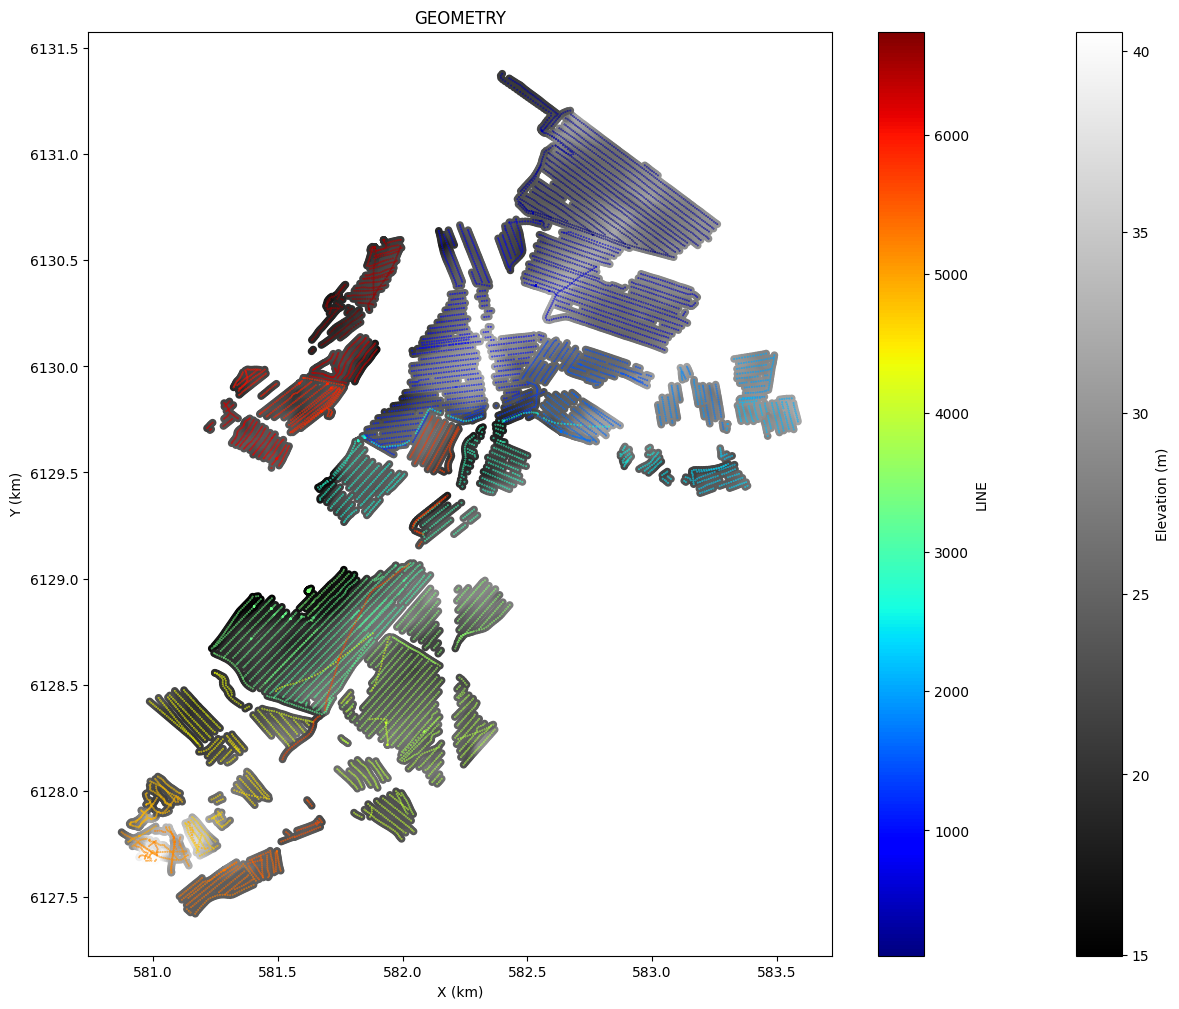

In [3]:
fig = ig.plot_data_xy(f_data_h5)

### Plot the observed data

plot_data: Found data set D1
plot_data: Using data set D1


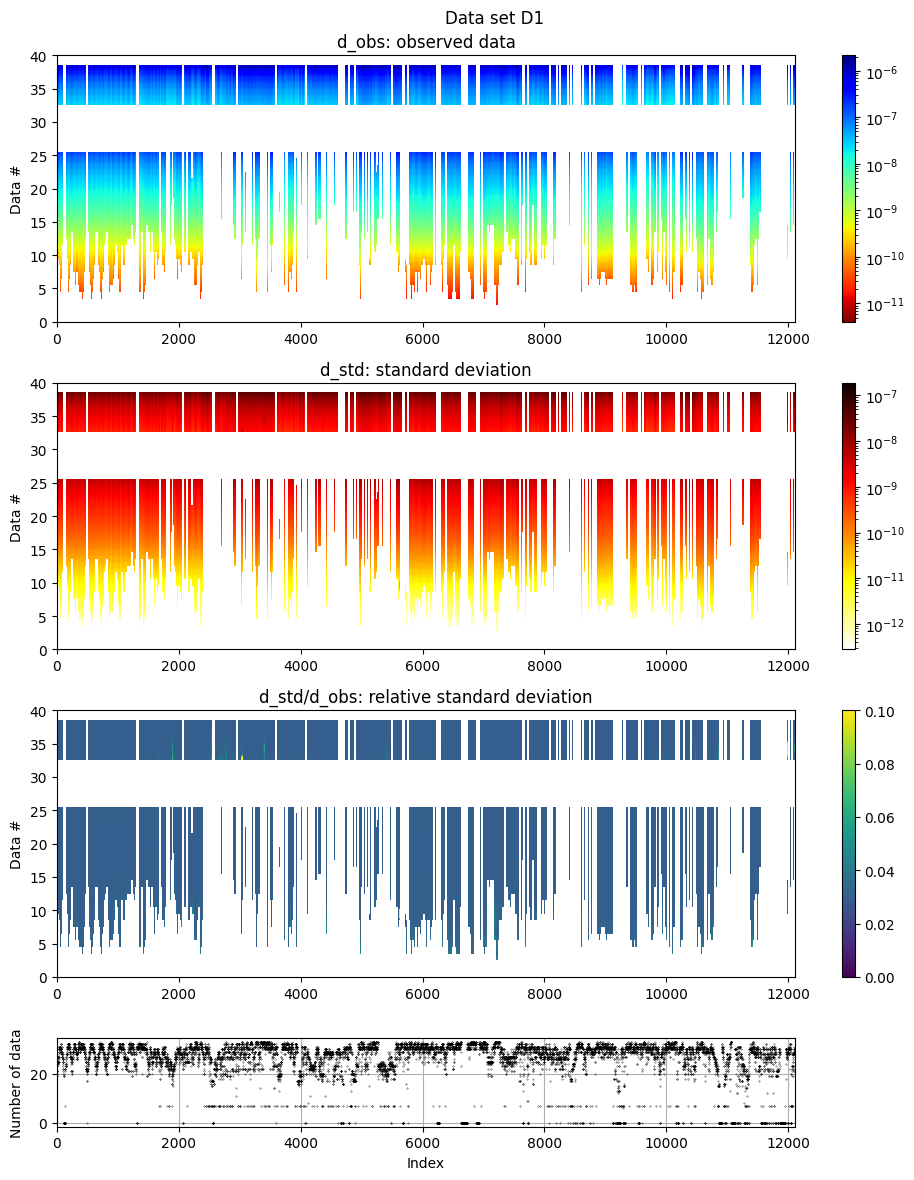

In [4]:
ig.plot_data(f_data_h5)

## Setup up the prior , $\rho(m,d)$
A lookup table of prior model parameters and corresponding prior data needs to be defined



### Prior model paramegters, $\rho(m)$: Setup the prior for the model parameters
In principle and arbitrarily complex prior can be used with INTEGRATE, quantifying information about both discrete and continuous model parameters, and modle parameters describing physical parameters, and geo related parameters.
Here, we consider using a simple generic resistivity only prior.



In [5]:
# A1. CONSTRUCT PRIOR MODEL OR USE EXISTING
N=100000
RHO_min = 10
RHO_max = 2500
RHO_max = 500
RHO_dist='log-uniform'
NLAY_min=4 
NLAY_max=4 
z_max = 90

useP=1
if useP==1:
    ## Layered model
    #f_prior_h5 = ig.prior_model_layered(N=N,lay_dist='chi2', NLAY_deg=5, z_max = z_max, RHO_dist='log-uniform', RHO_min=RHO_min, RHO_max=RHO_max)
    #f_prior_h5 = ig.prior_model_layered(N=N,lay_dist='uniform', z_max = z_max, NLAY_min=1, NLAY_max=3, RHO_dist='log-uniform', RHO_min=RHO_min, RHO_max=RHO_max)
    f_prior_h5 = ig.prior_model_layered(N=N,lay_dist='uniform', 
                                        z_max = z_max, 
                                        NLAY_min=NLAY_min, 
                                        NLAY_max=NLAY_max, 
                                        RHO_dist=RHO_dist, 
                                        RHO_min=RHO_min, 
                                        RHO_max=RHO_max)
elif useP==2:
    ## N layer model with increasing thickness
    f_prior_h5 = ig.prior_model_workbench(N=N, 
                                          RHO_mean=45, 
                                          RHO_std=45, 
                                          RHO_dist='log-normal', 
                                          z_max = z_max, 
                                          nlayers=1, 
                                          RHO_min = RHO_min, 
                                          RHO_max = RHO_max)
    #f_prior_h5 = ig.prior_model_workbench(N=N, z_max= 30, nlayers=20, RHO_min = RHO_min, RHO_max = RHO_max)
    f_prior_h5 = ig.prior_model_workbench(N=N, z_max = z_max, nlayers=NLAY_max, RHO_dist=RHO_dist, RHO_min = RHO_min, RHO_max = RHO_max)
    
else:
    f_prior_h5 = 'existing_prior.h5'

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [00:01<00:00, 51715.56it/s]


Saving prior model to PRIOR_UNIFORM_NL_4-4_log-uniform_N100000.h5


/mnt/c/Users/thoma/PROGRAMMING/integrate_module/integrate/integrate_plot.py:873: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0,1].set_xticklabels(['$10^{%3.1f}$'%i for i in ax[0,1].get_xticks()])


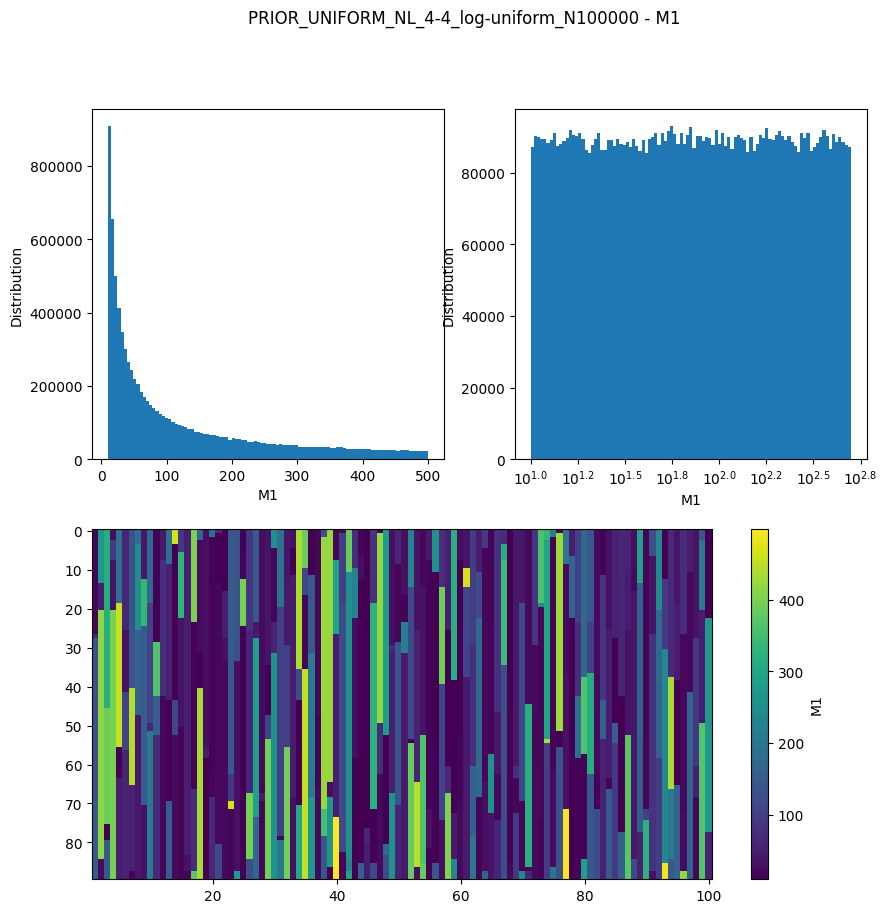

In [6]:
ig.plot_prior_stats(f_prior_h5)

### Prior data, $\rho(d)$
The prior data, i.e. the forwward response of of the realizations of the prior needs to be computed. Here we use only tTEM data, so onæy on type (tTEM) of data is computed.

In [7]:
f_prior_data_h5 = ig.prior_data_gaaem(f_prior_h5, file_gex)

N=100000, N_in=100000
Creating a copy of PRIOR_UNIFORM_NL_4-4_log-uniform_N100000.h5 as PRIOR_UNIFORM_NL_4-4_log-uniform_N100000_TX07_20230828_2x4_RC20-33_Nh280_Nf12.h5


100%|█████████████████████████████████████████████████████████████████████████████████| 6250/6250 [05:54<00:00, 17.65it/s]


Concatenating D_chunks
D.shape (100000, 40)
Time elapsed: 354.8 s, for 100000 soundings. 3.548 ms/sounding. 281.8it/s


## Sample the posterior $\sigma(\mathbf{m})$

The posterior distribution is sampling using the extended rejection sampler.

In [8]:

N_use = 10000000
#f_prior_data_h5 = 'gotaelv2_N1000000_fraastad_ttem_Nh280_Nf12.h5'
updatePostStat =True
f_post_h5 = ig.integrate_rejection(f_prior_data_h5, f_data_h5, N_use = N_use, parallel=1, updatePostStat=updatePostStat, showInfo=1)




Running: integrate_rejection.py PRIOR_UNIFORM_NL_4-4_log-uniform_N100000_TX07_20230828_2x4_RC20-33_Nh280_Nf12.h5 FANGEL_AVG.h5 --autoT 1 --N_use 10000000 --ns 400 -parallel 1 --updatePostStat 1
psm_7b592fb8
nsoundings:12118, N_use:100000, nd:40
Writing results to  POST_FANGEL_AVG_PRIOR_UNIFORM_NL_4-4_log-uniform_N100000_TX07_20230828_2x4_RC20-33_Nh280_Nf12_Nu100000_aT1.h5
Using 8 parallel threads.


100%|███████████████████████████████████████████████████████████████████████████████| 12118/12118 [03:52<00:00, 52.02it/s]


T_av=30.1, Time=233.1s/12118 soundings ,19.234ms/sounding
Writing to file:  POST_FANGEL_AVG_PRIOR_UNIFORM_NL_4-4_log-uniform_N100000_TX07_20230828_2x4_RC20-33_Nh280_Nf12_Nu100000_aT1.h5
PRIOR_UNIFORM_NL_4-4_log-uniform_N100000_TX07_20230828_2x4_RC20-33_Nh280_Nf12.h5: M1.is_discrete=0
PRIOR_UNIFORM_NL_4-4_log-uniform_N100000_TX07_20230828_2x4_RC20-33_Nh280_Nf12.h5: M2.is_discrete=0
D1: NOT RECOGNIZED
M1: CONTINUOUS
Creating /M1/Mean
Creating /M1/Median
Creating /M1/Std


100%|█████████████████████████████████████████████████████████████████████████████| 12118/12118 [00:09<00:00, 1243.38it/s]


M2: CONTINUOUS
Creating /M2/Mean
Creating /M2/Median
Creating /M2/Std


100%|████████████████████████████████████████████████████████████████████████████| 12118/12118 [00:00<00:00, 15112.17it/s]


## Plot some statistics from $\sigma(\mathbf{m})$

### The temperature refer to the annealing temperature used by the extended rejection sampler, in order to get 'enough' realizations.
T=1, implies no anealing has occurred. Higher values of T implies increasingly difficulty of fitting the data within the noise, suggesting either that the lookup table size is too small and/or that the prior is not consistent with the data.

(1, 100)
EV_min=-100.000000, EV_max=0.000000
[19 20 20 ... 30 31 30]


1

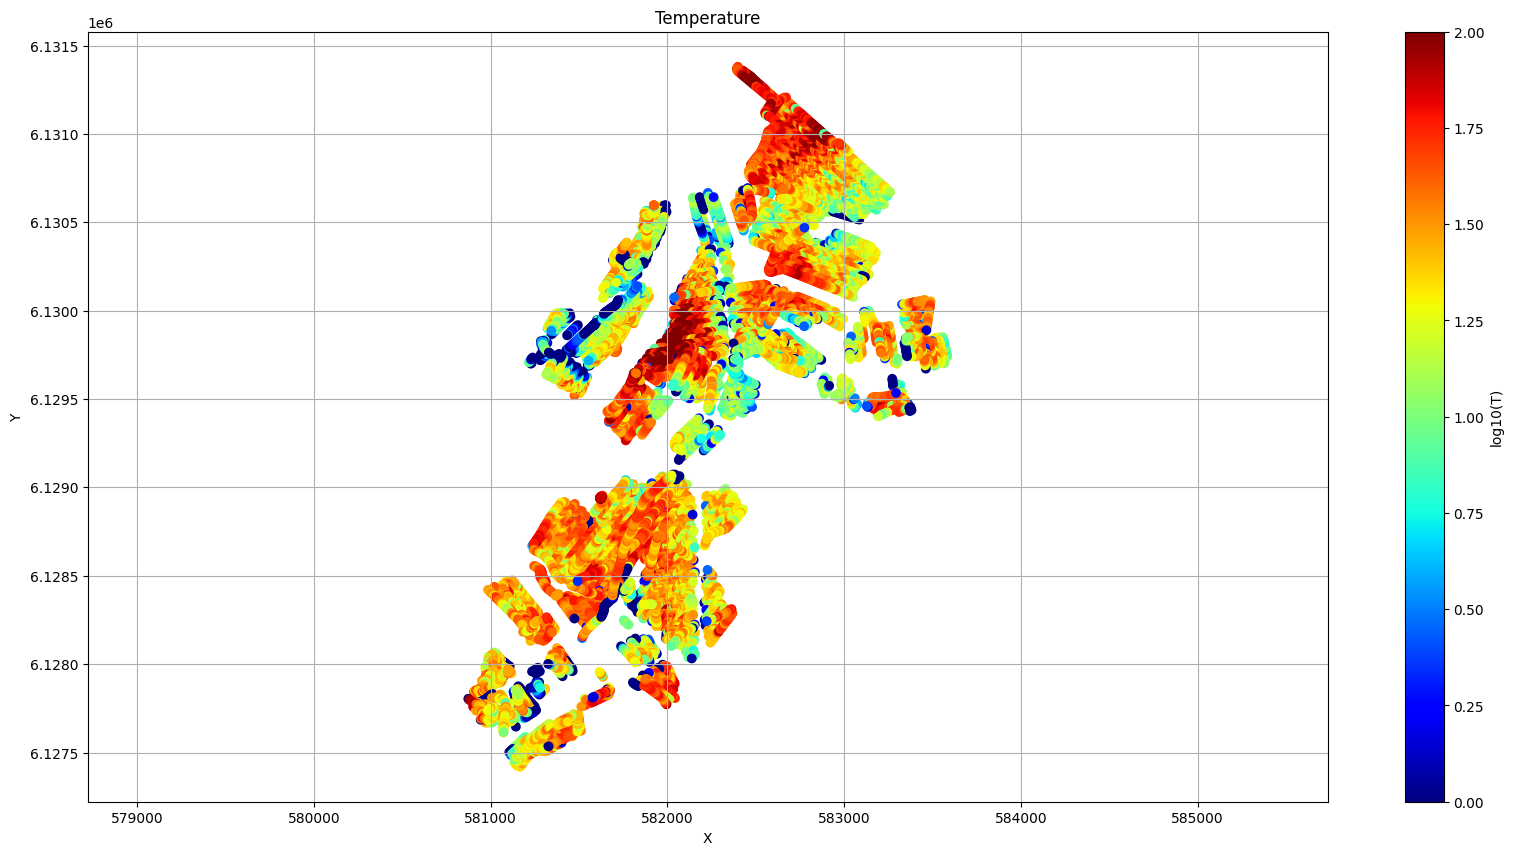

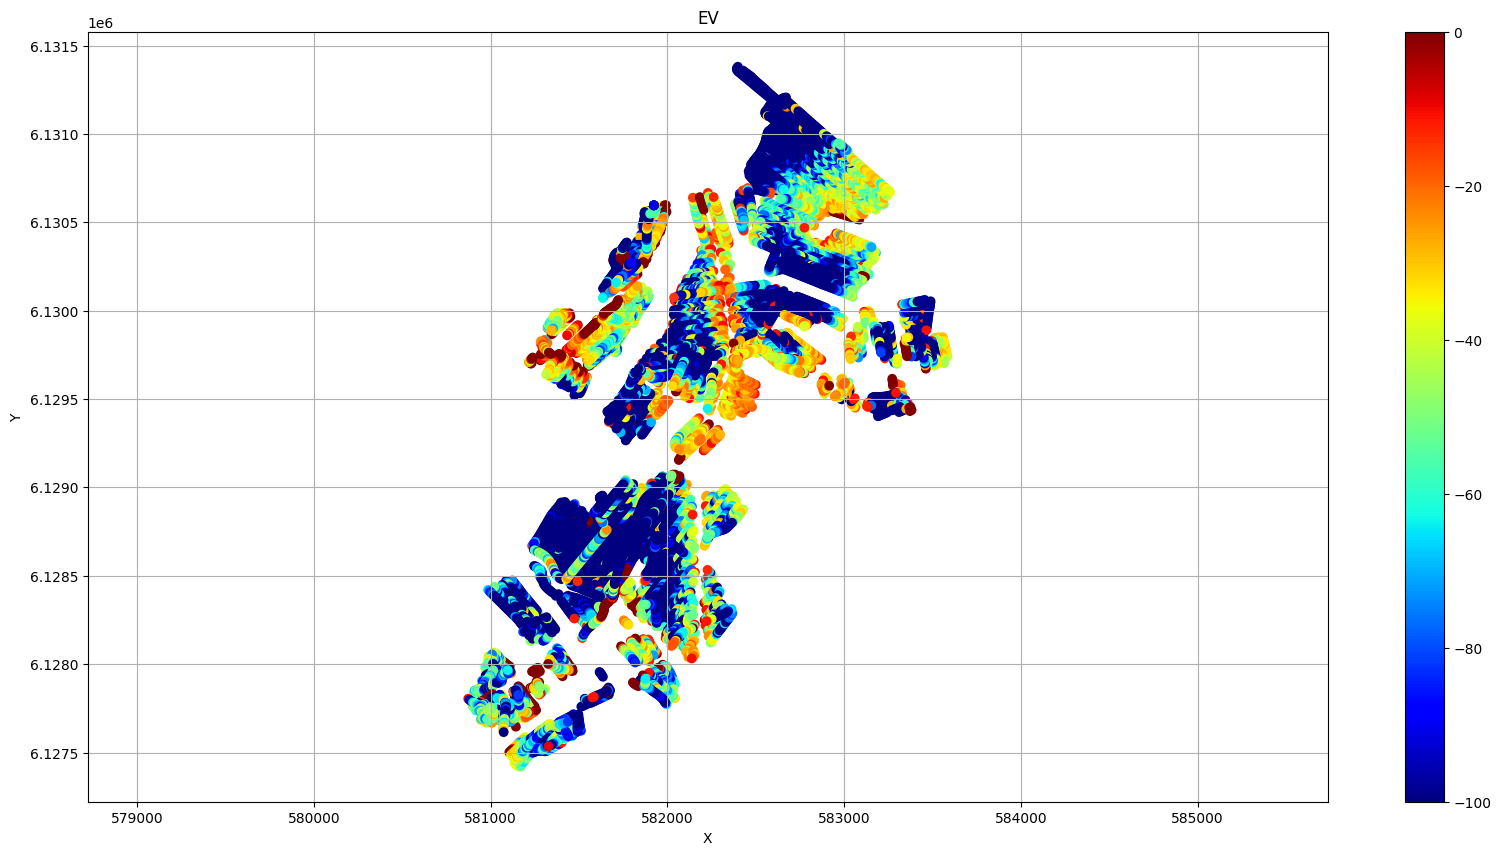

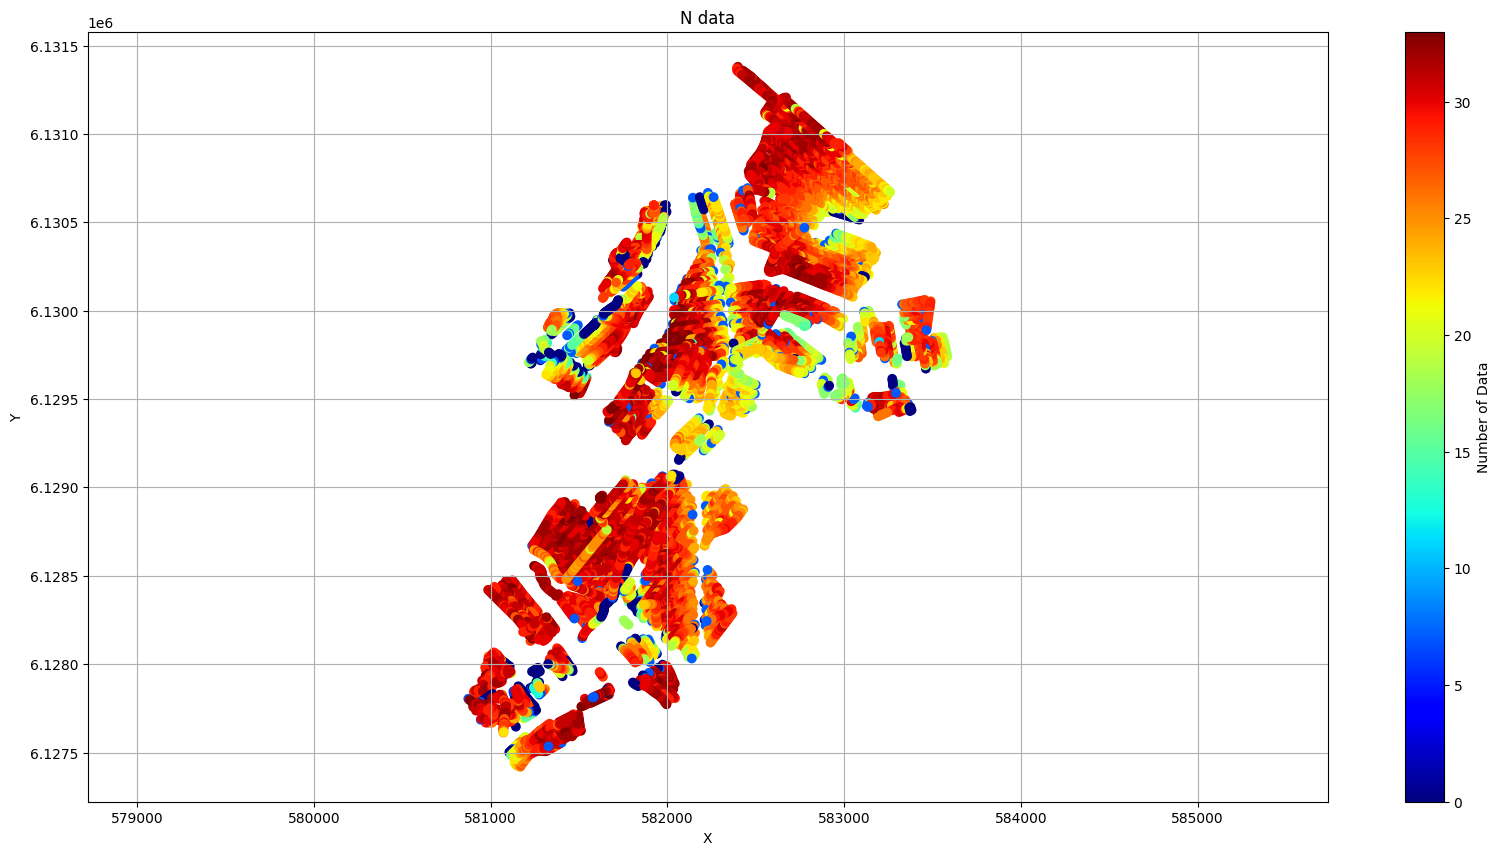

In [9]:
# Plot the Temperature used for inversion
ig.plot_T_EV(f_post_h5, pl='T')
ig.plot_T_EV(f_post_h5, pl='EV')
ig.plot_T_EV(f_post_h5, pl='ND')
#

12.546050960640757
11.883555643684018
24.653527572775374
25.742904155613953


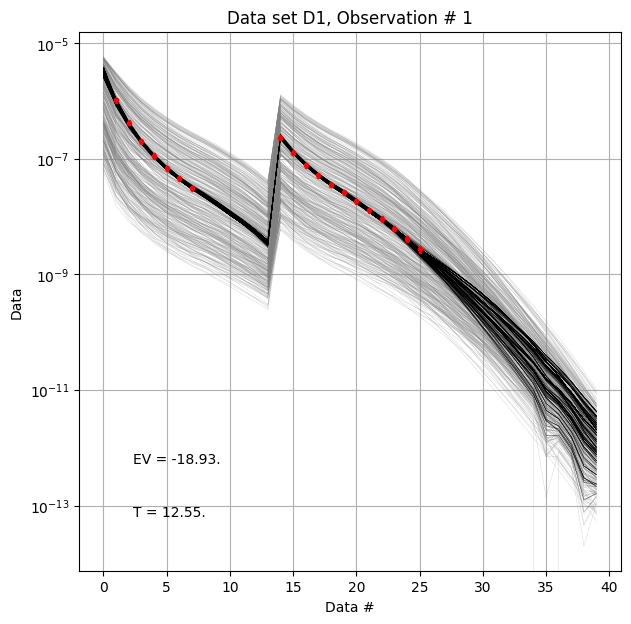

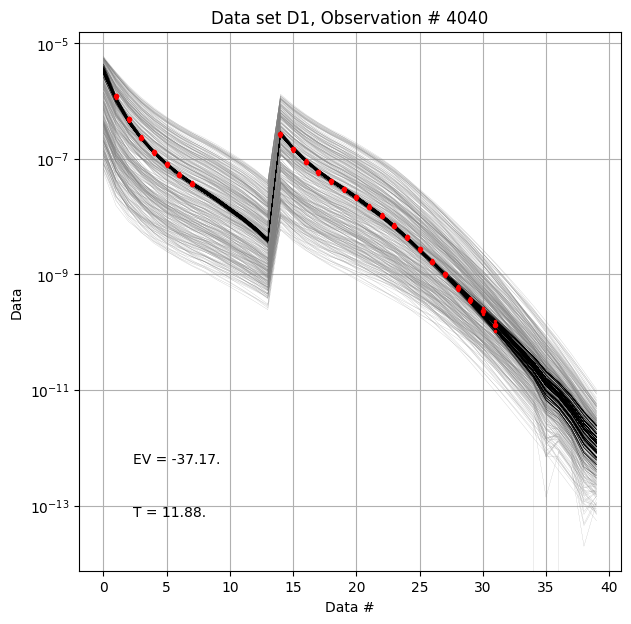

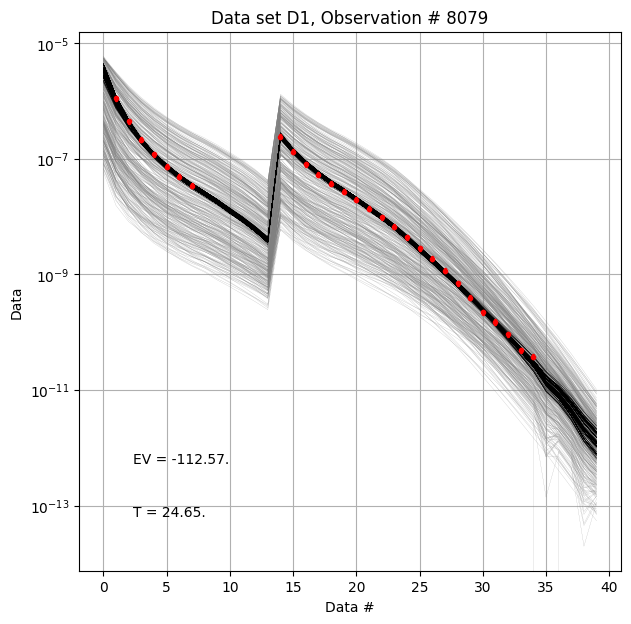

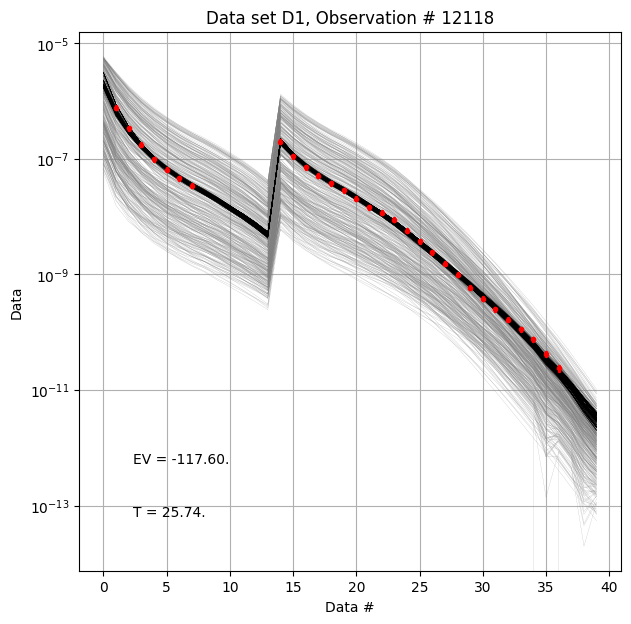

In [10]:
import h5py
with h5py.File(f_data_h5,'r') as f_prior:
    nd=f_prior['UTMX'].shape[0]


i1 = np.linspace(0,nd-1,4).astype(int)
for i in i1:
    ig.plot_data_prior_post(f_post_h5, i_plot = i)
    #ig.plot_data_prior_post(f_post_h5, i_plot = 1199)

0
Plot profile for all model parameters
1
Plotting profile /M1 from POST_FANGEL_AVG_PRIOR_UNIFORM_NL_4-4_log-uniform_N100000_TX07_20230828_2x4_RC20-33_Nh280_Nf12_Nu100000_aT1.h5
[10, 500]
jet
[10, 500]


/mnt/c/Users/thoma/PROGRAMMING/integrate_module/integrate/integrate_plot.py:564: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im1 = ax[0].pcolormesh(ID[:,i1:i2], ZZ[:,i1:i2], Mean[:,i1:i2],
/mnt/c/Users/thoma/PROGRAMMING/integrate_module/integrate/integrate_plot.py:573: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2 = ax[1].pcolormesh(ID[:,i1:i2], ZZ[:,i1:i2], Median[:,i1:i2],
/mnt/c/Users/thoma/PROGRAMMING/integrate_module/integrate/integrate_plot.py:583: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or d

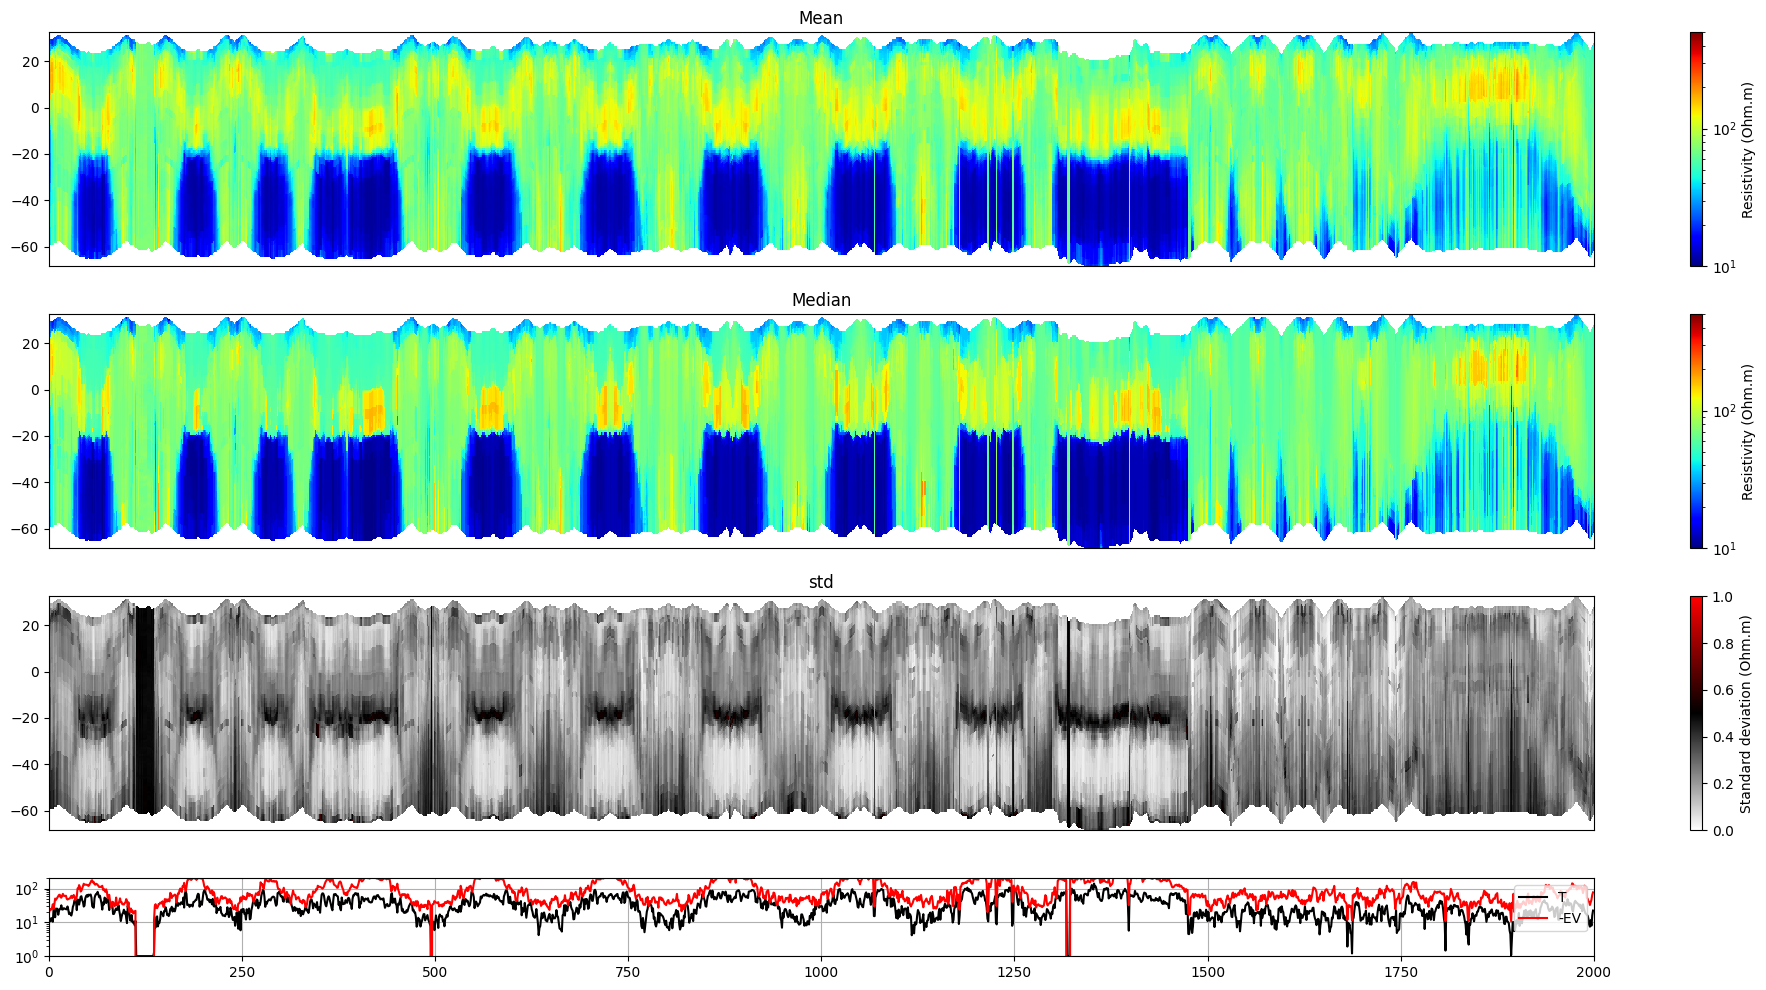

2
Plotting profile /M2 from POST_FANGEL_AVG_PRIOR_UNIFORM_NL_4-4_log-uniform_N100000_TX07_20230828_2x4_RC20-33_Nh280_Nf12_Nu100000_aT1.h5
[10, 500]
jet
[10, 500]
Only nm=1, model parameters. no profile will be plot


1

In [11]:
ig.plot_profile(f_post_h5, i1=0, i2=np.min([2000,nd]), cmap='jet', hardcopy=hardcopy)

Plotting Feature 0 from /M1/Mean
(12118,)


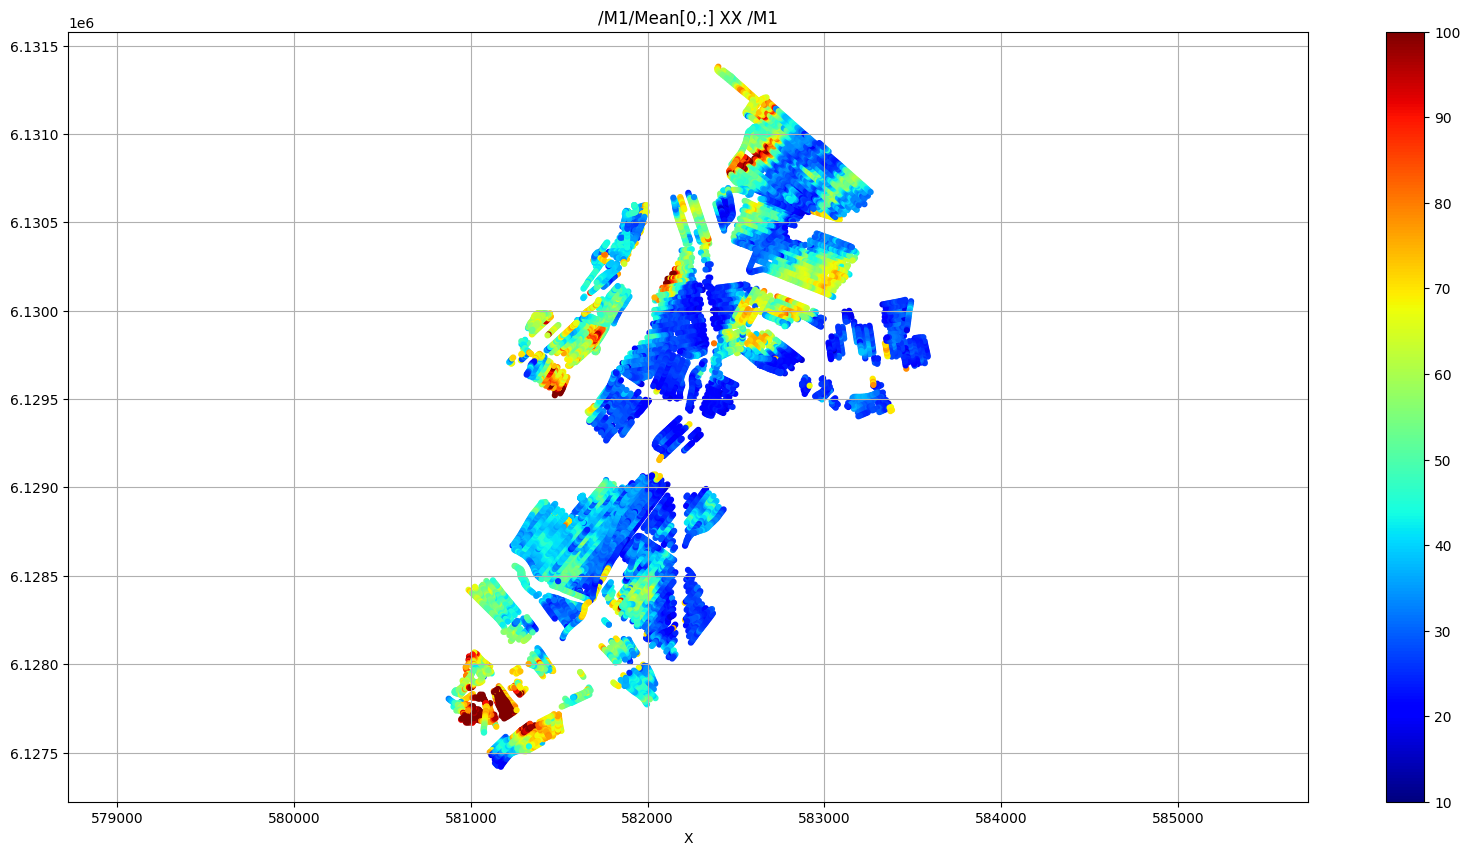

Plotting Feature 5 from /M1/Mean
(12118,)


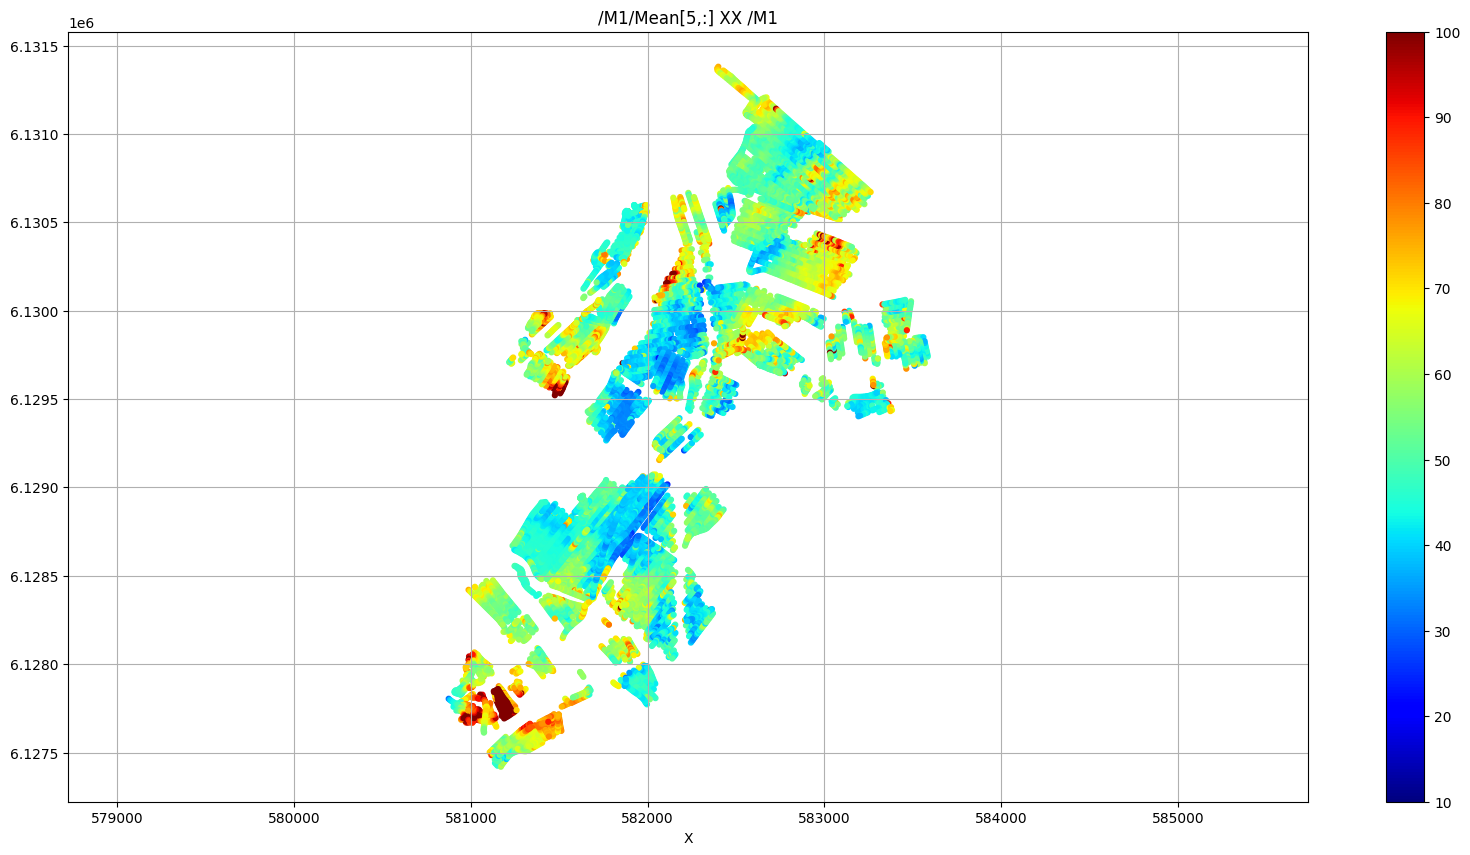

Plotting Feature 10 from /M1/Mean
(12118,)


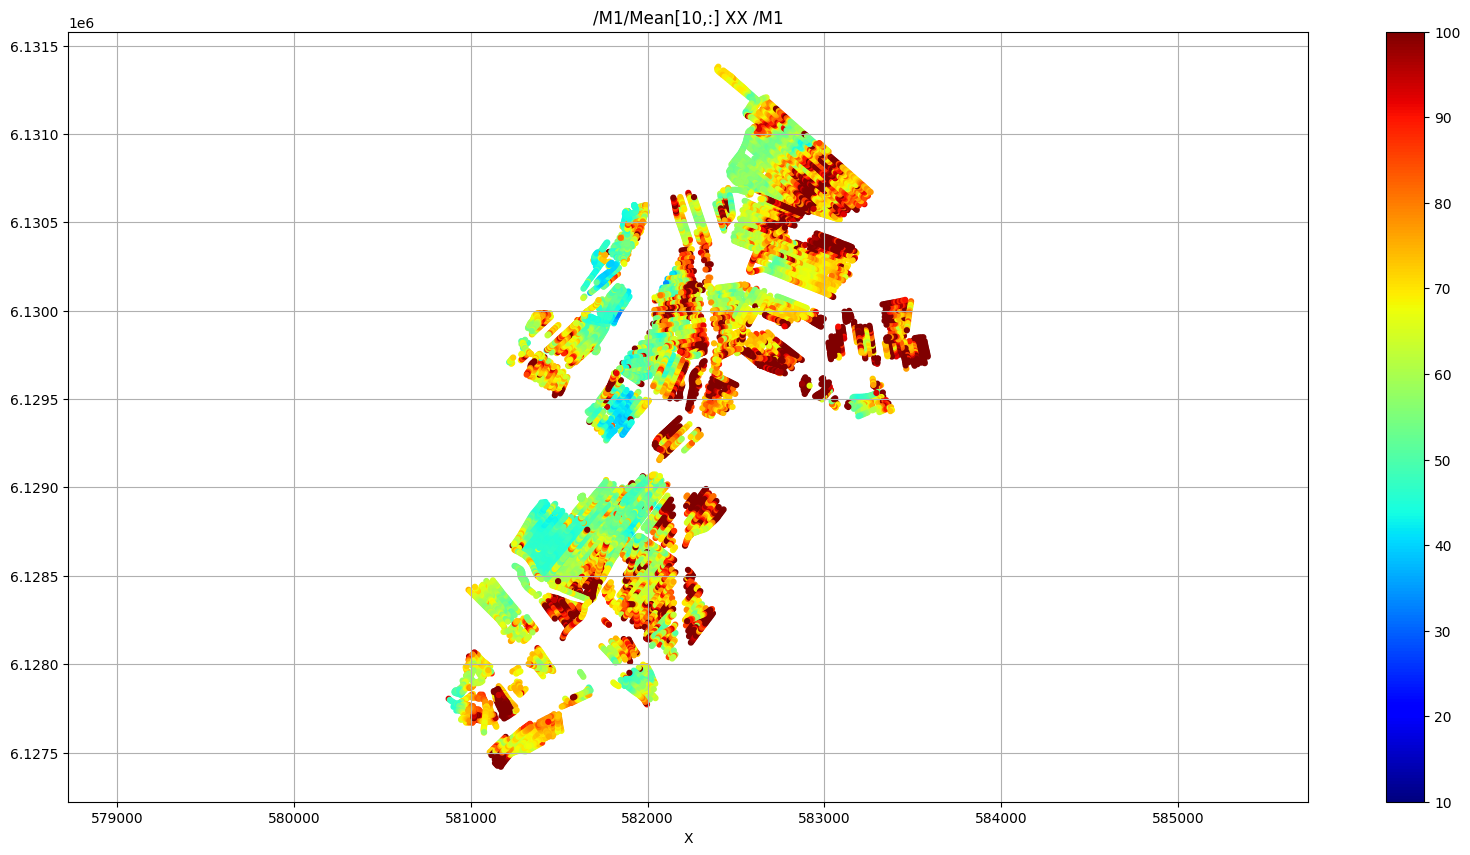

Plotting Feature 15 from /M1/Mean
(12118,)


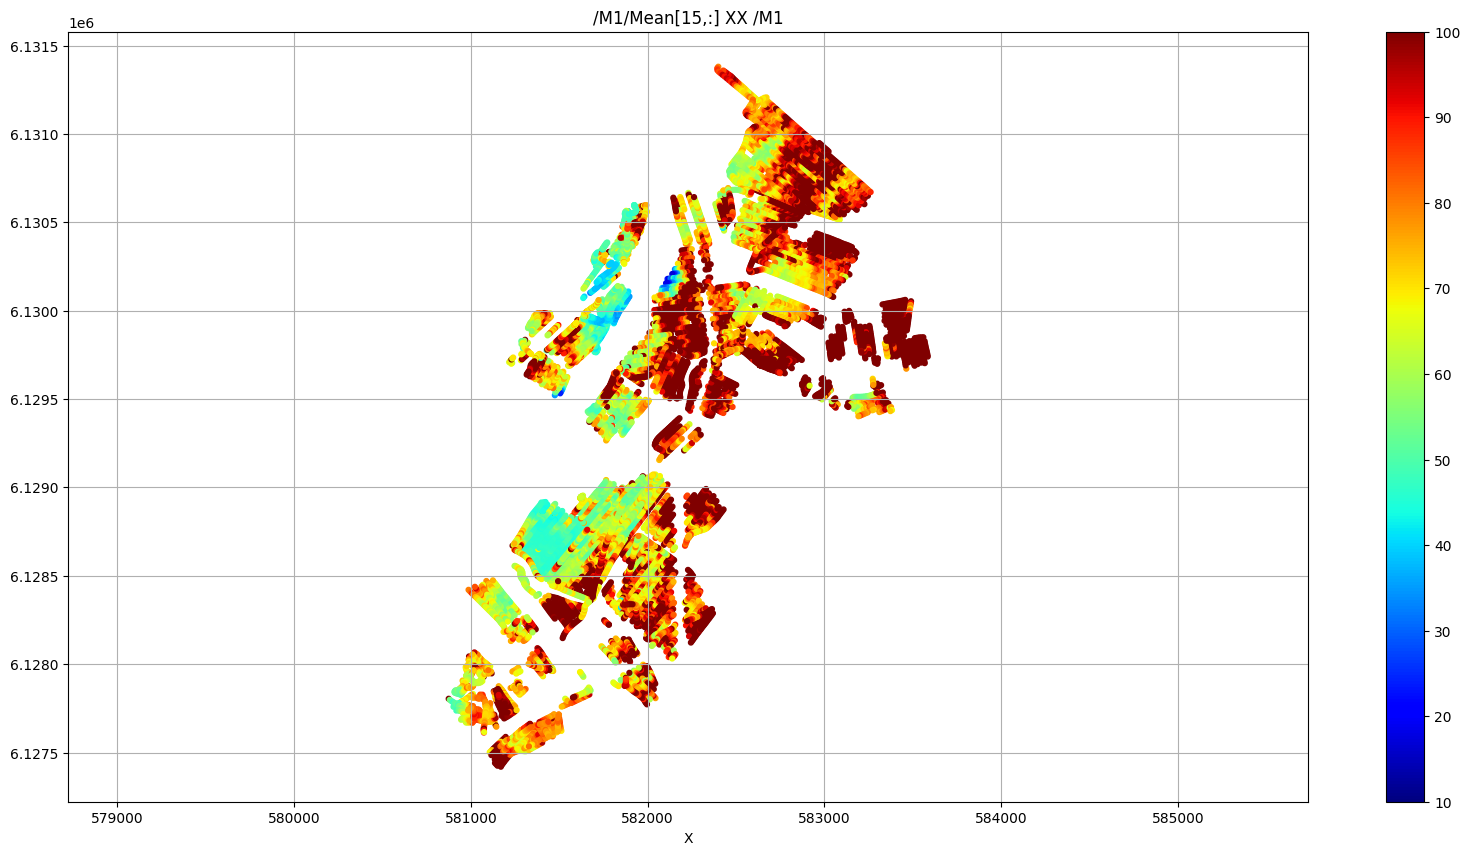

Plotting Feature 20 from /M1/Mean
(12118,)


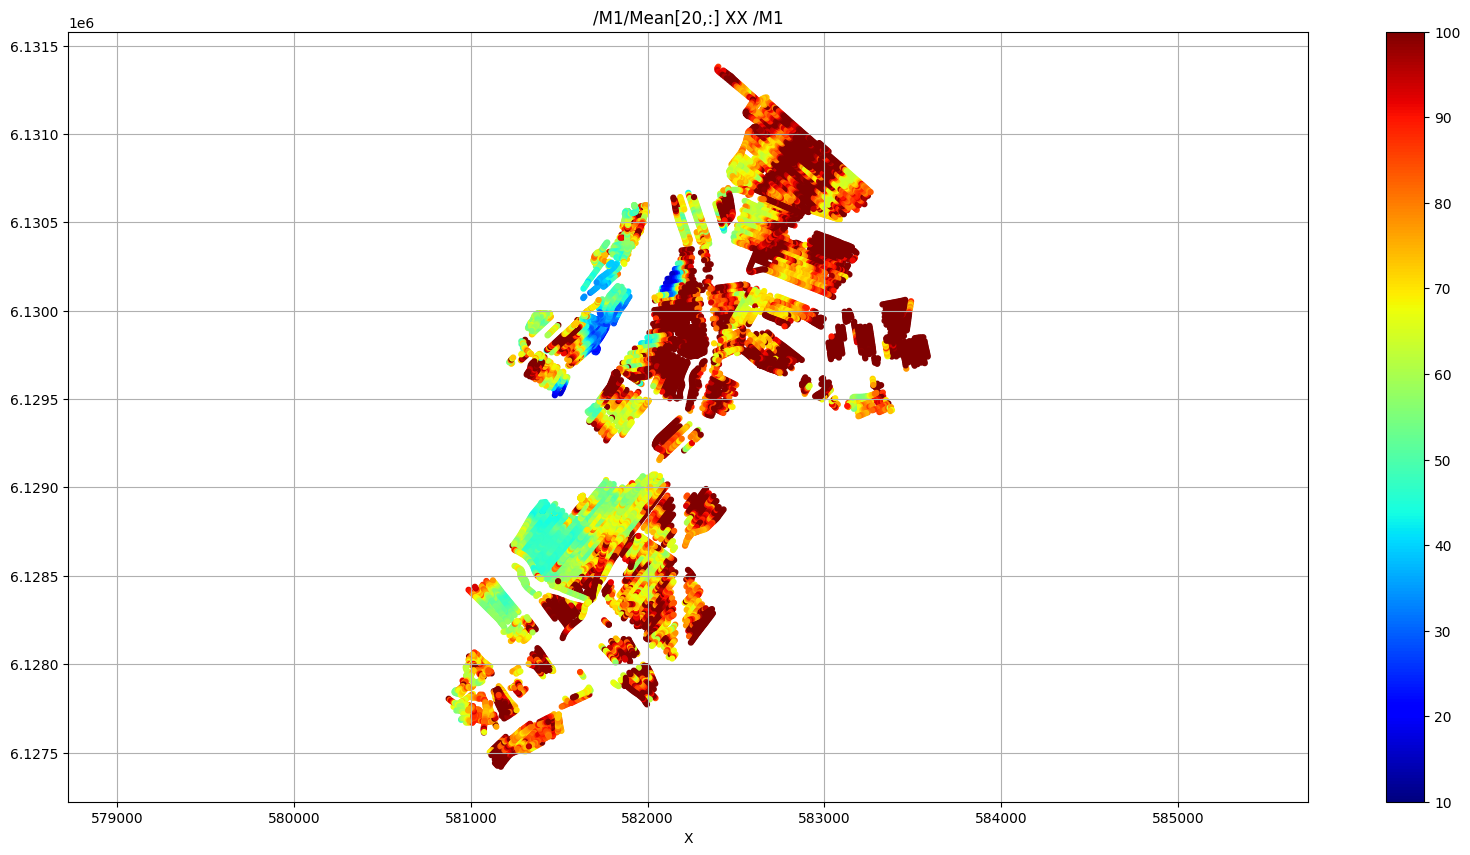

Plotting Feature 25 from /M1/Mean
(12118,)


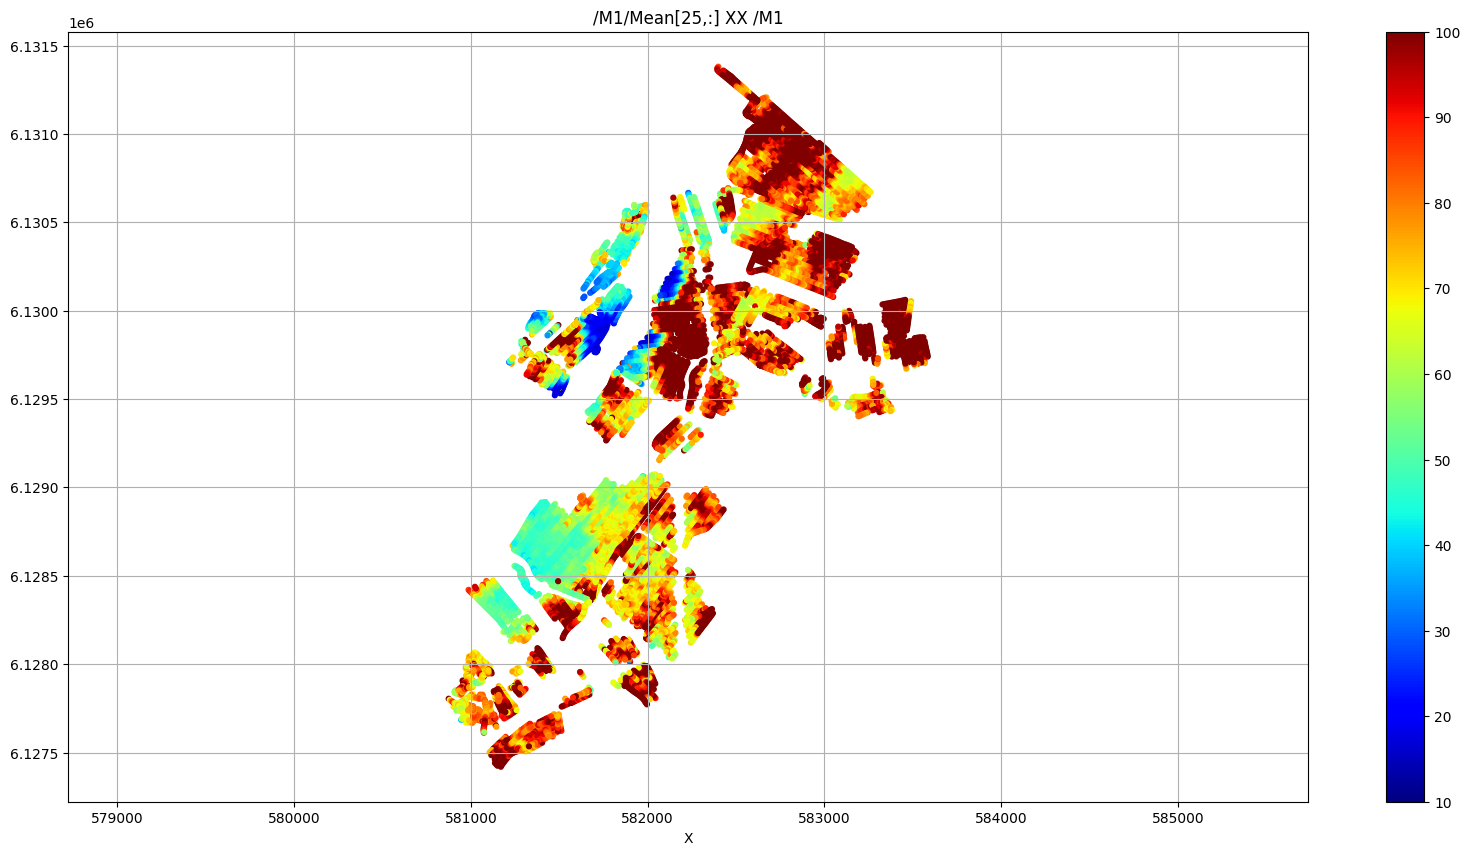

Plotting Feature 30 from /M1/Mean
(12118,)


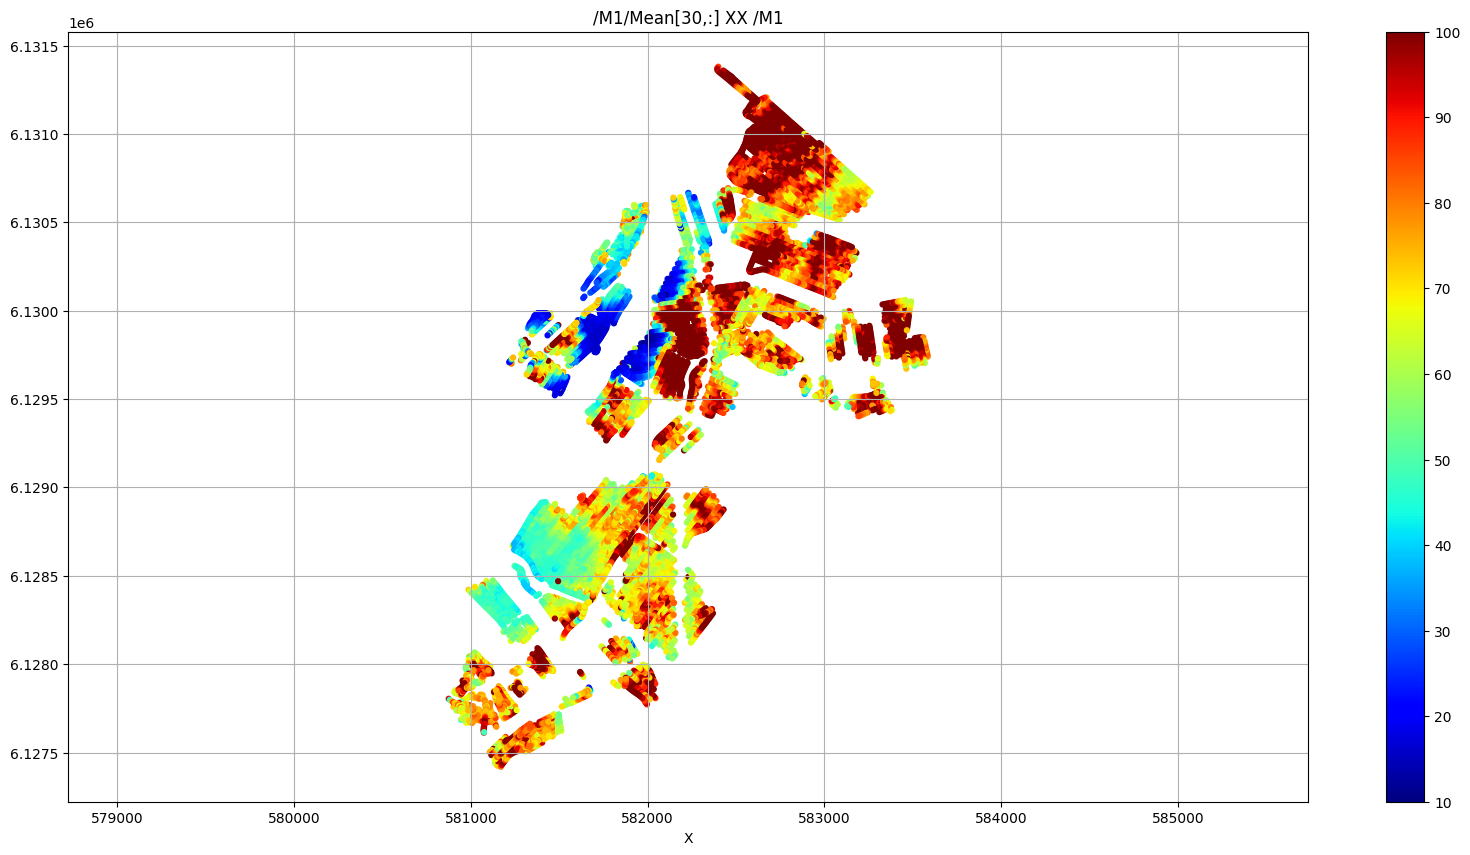

Plotting Feature 35 from /M1/Mean
(12118,)


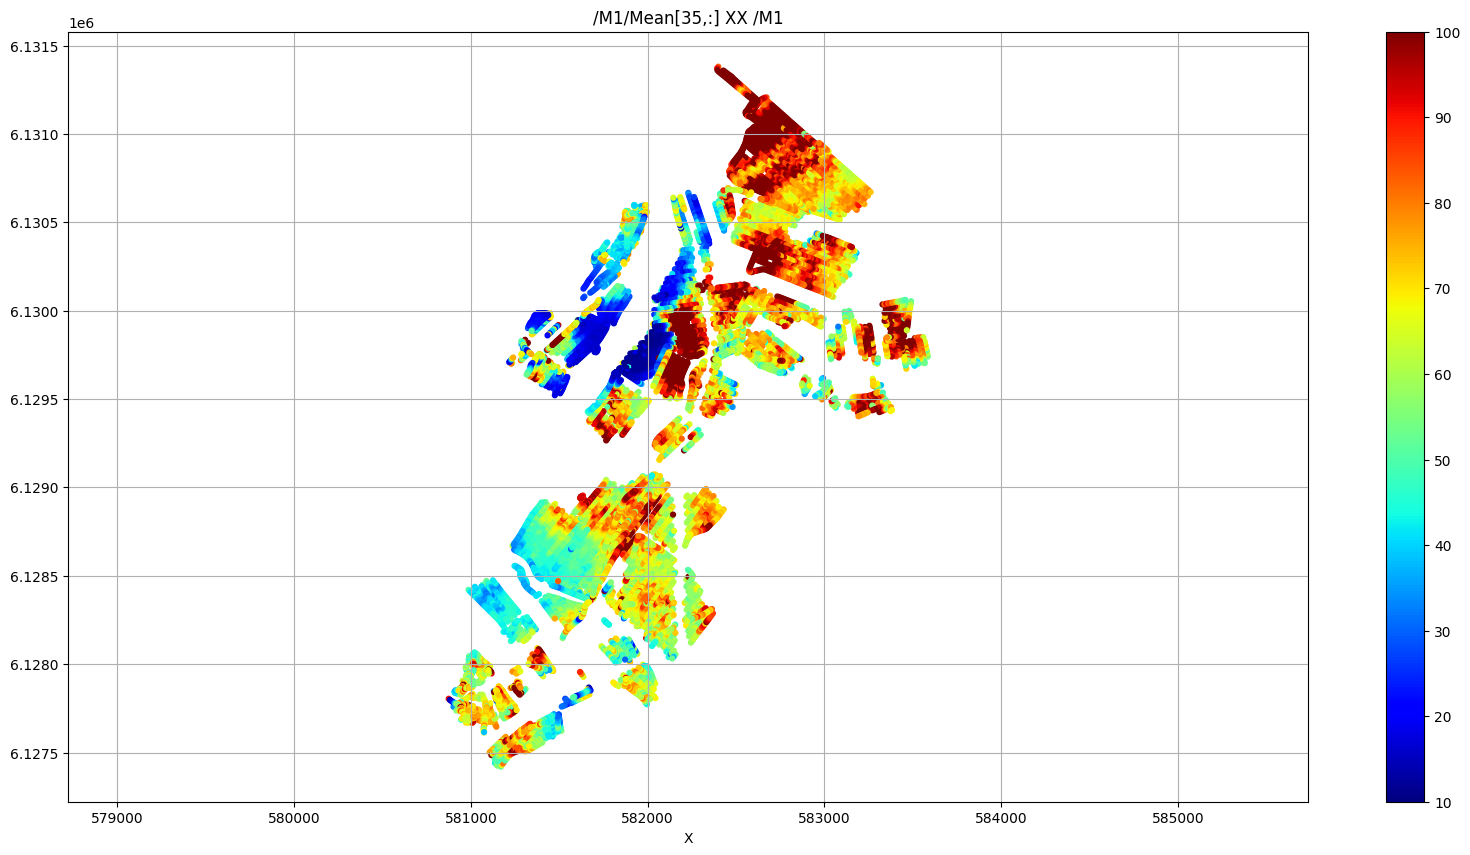

Plotting Feature 40 from /M1/Mean
(12118,)


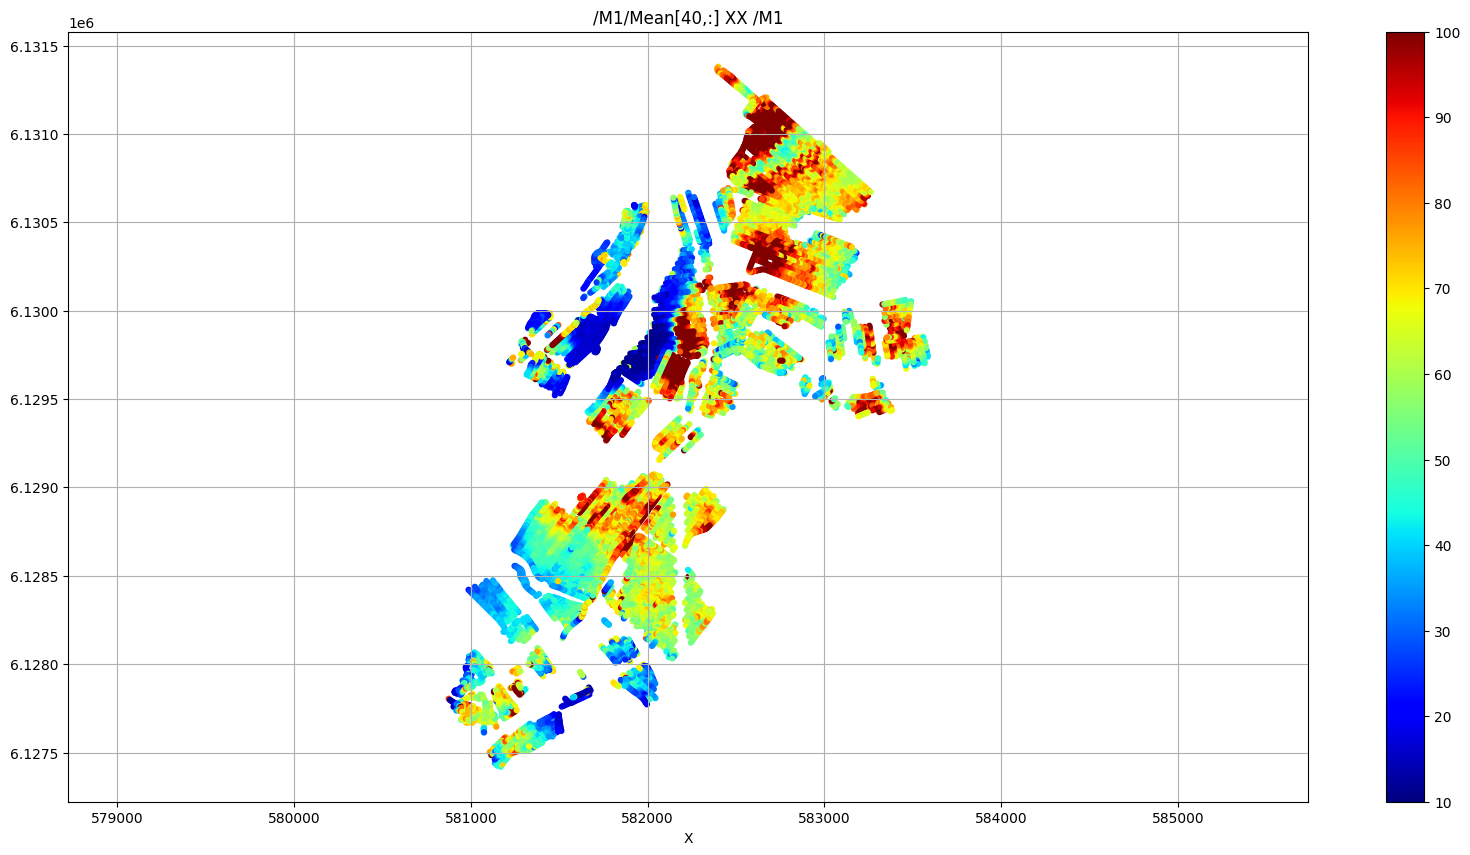

Plotting Feature 45 from /M1/Mean
(12118,)


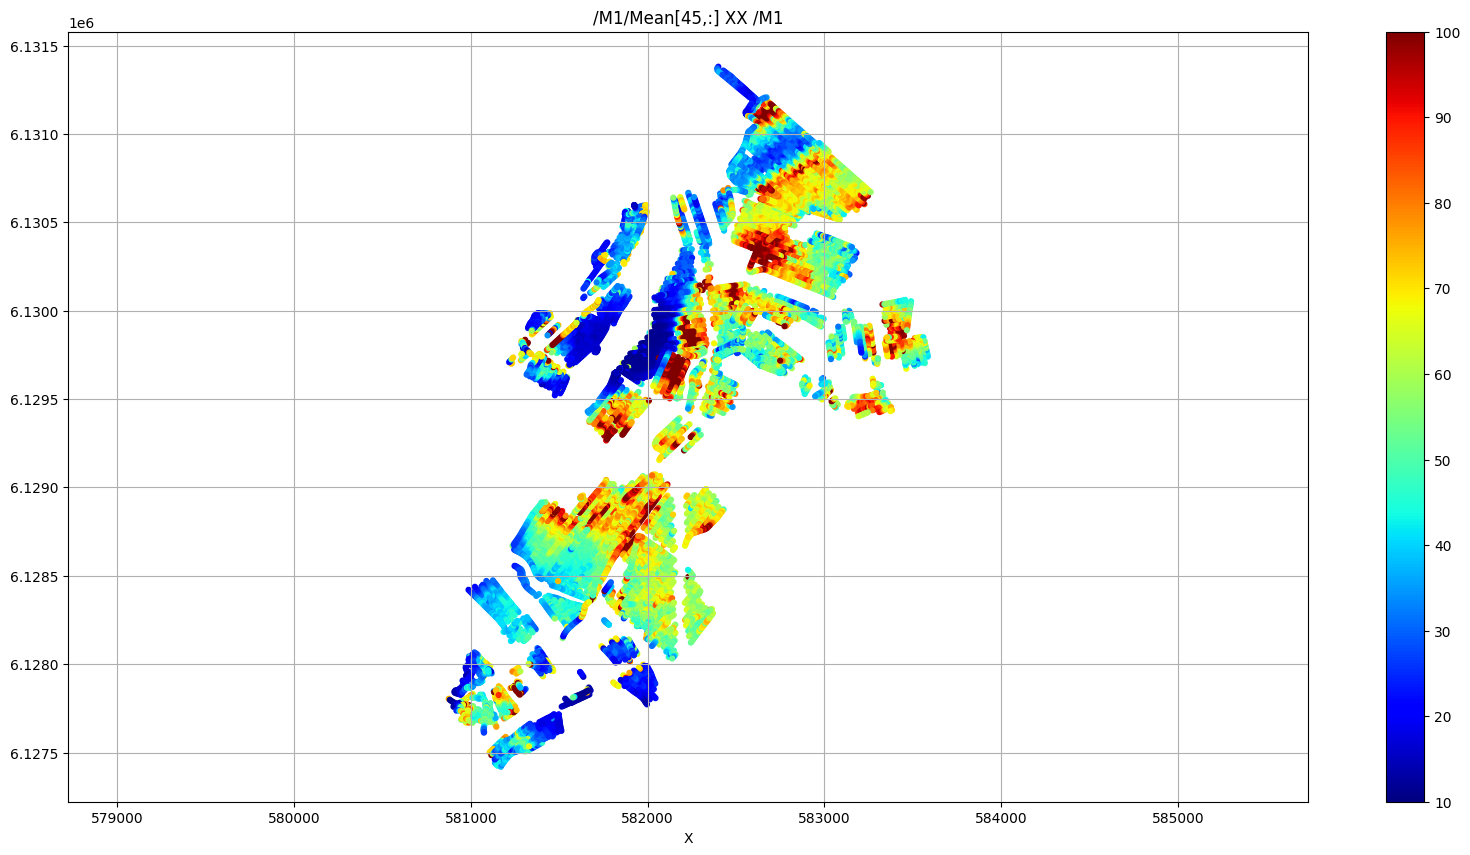

Plotting Feature 50 from /M1/Mean
(12118,)


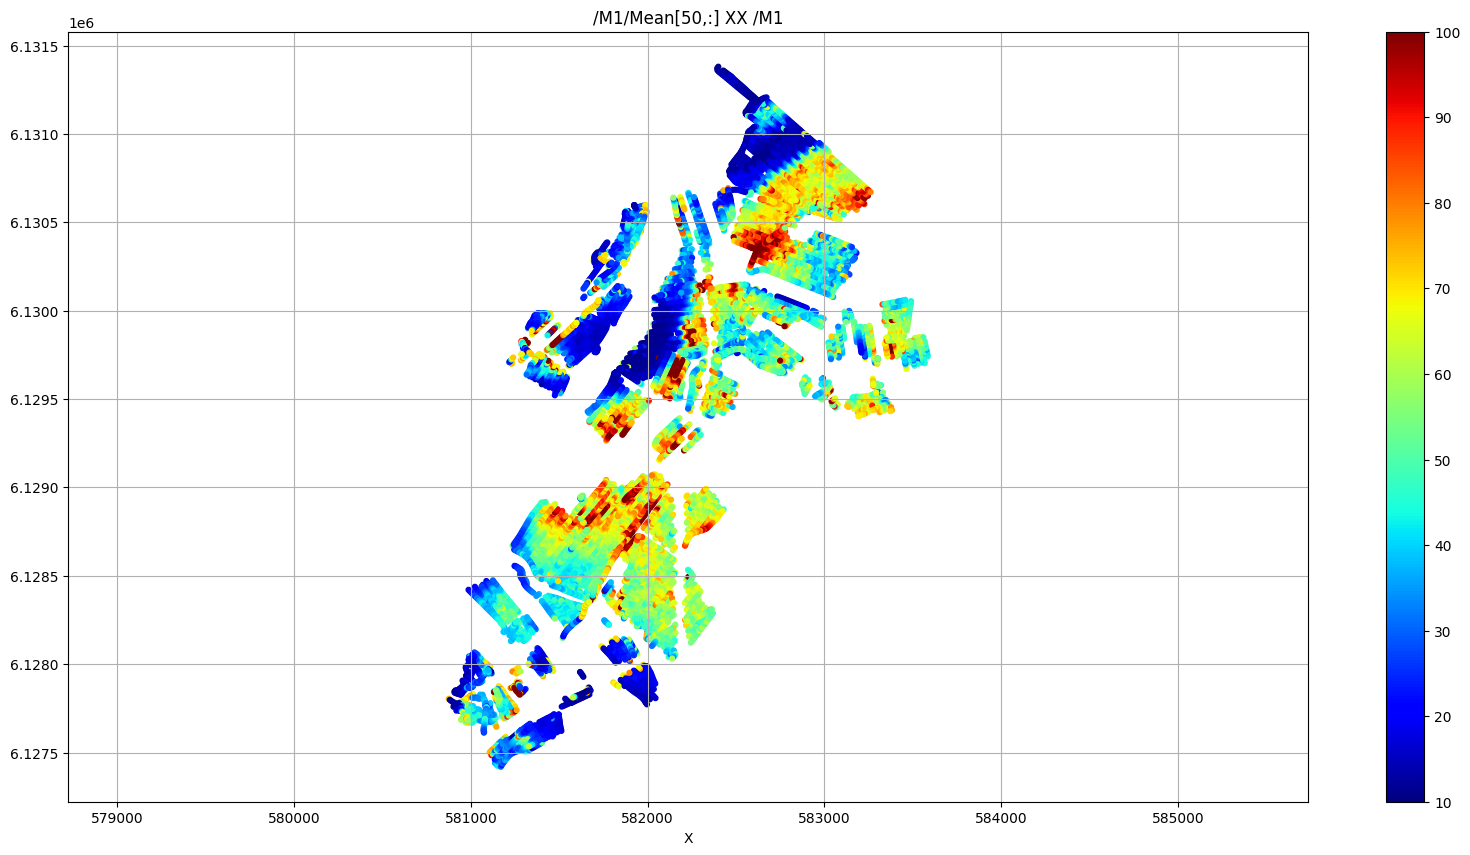

Plotting Feature 55 from /M1/Mean
(12118,)


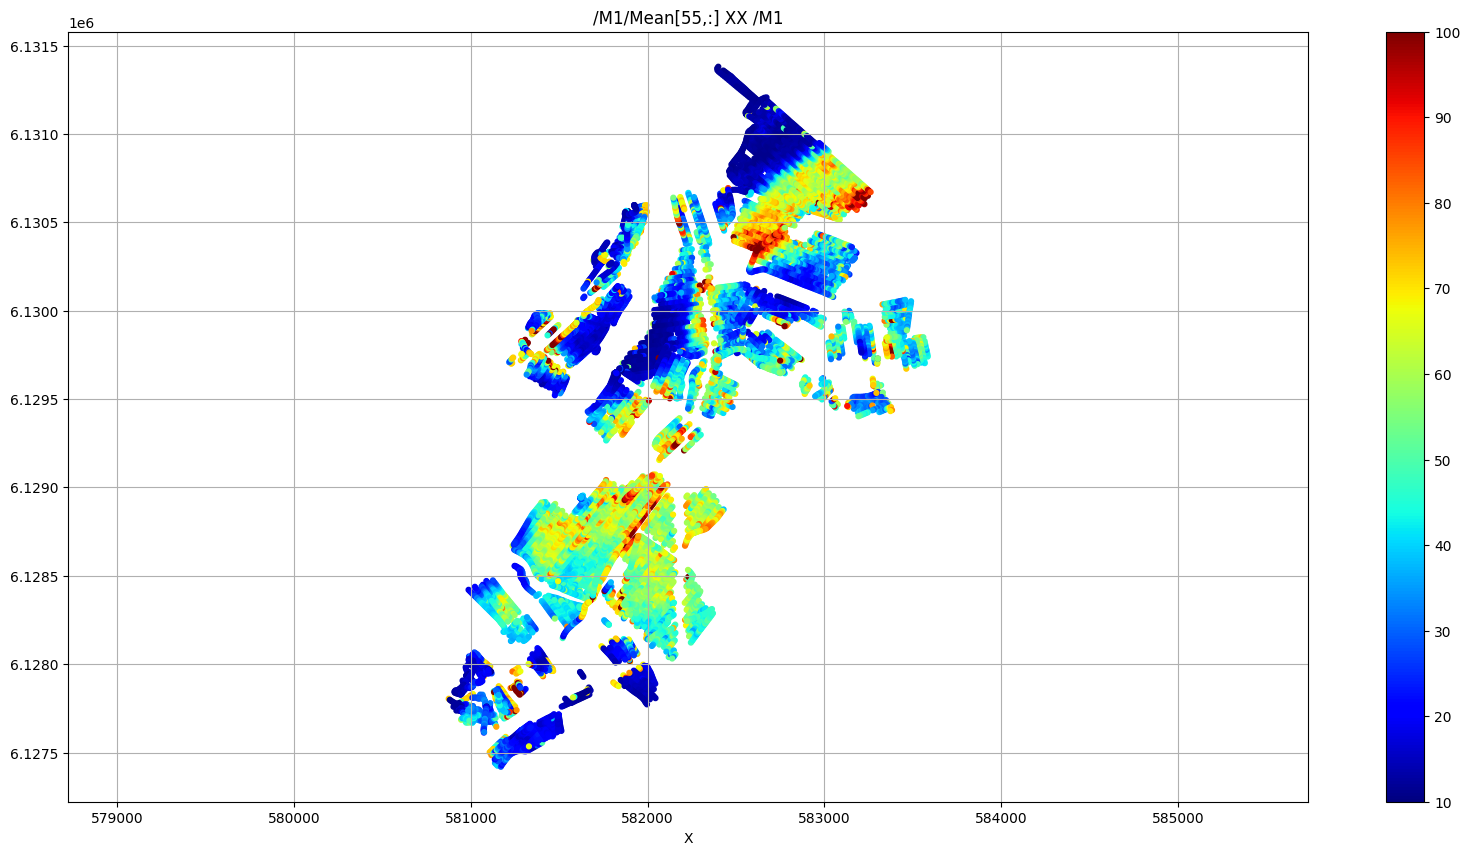

Plotting Feature 60 from /M1/Mean
(12118,)


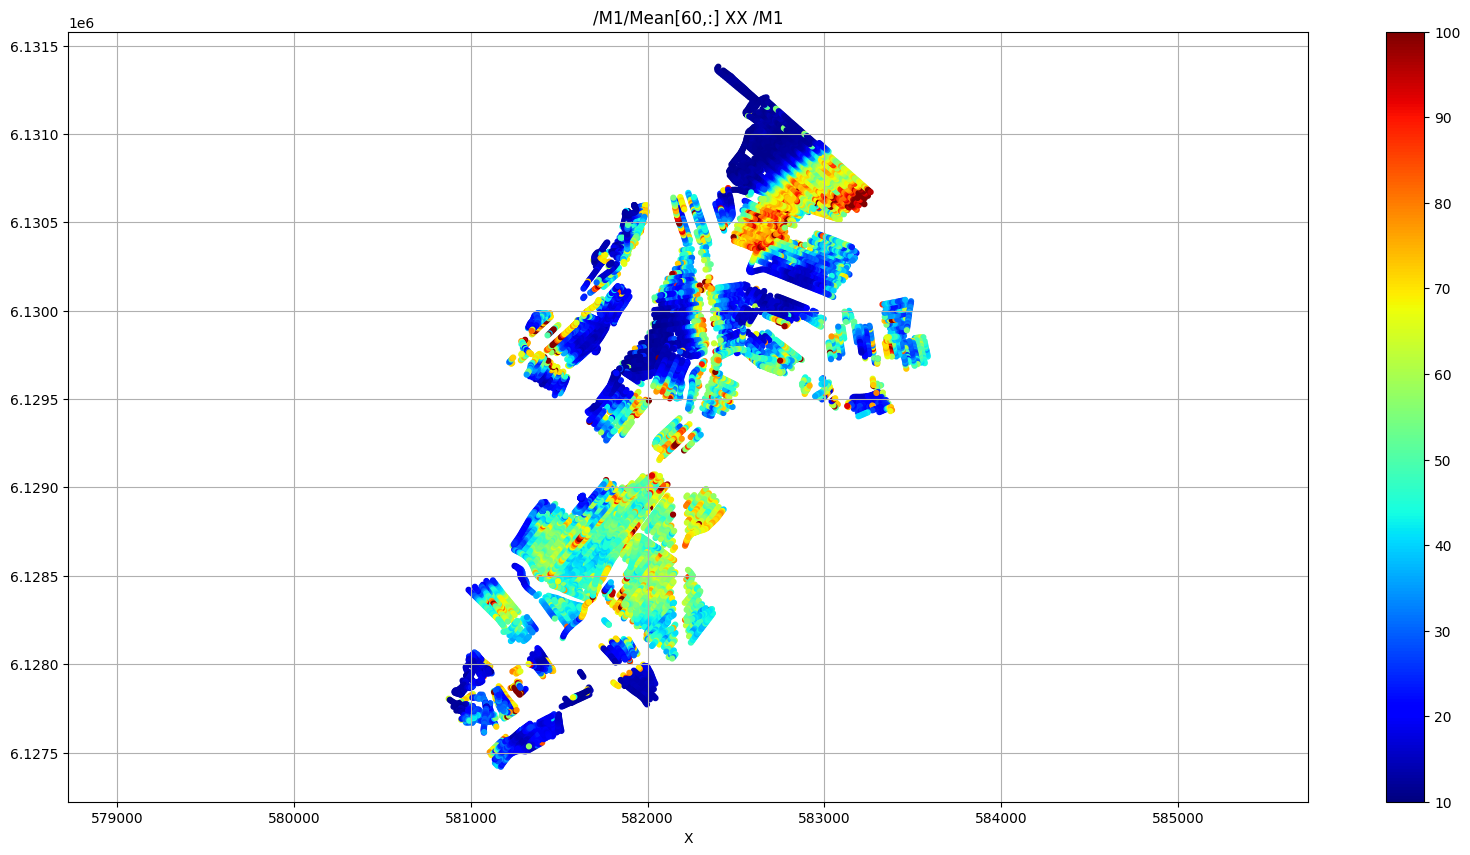

Plotting Feature 65 from /M1/Mean
(12118,)


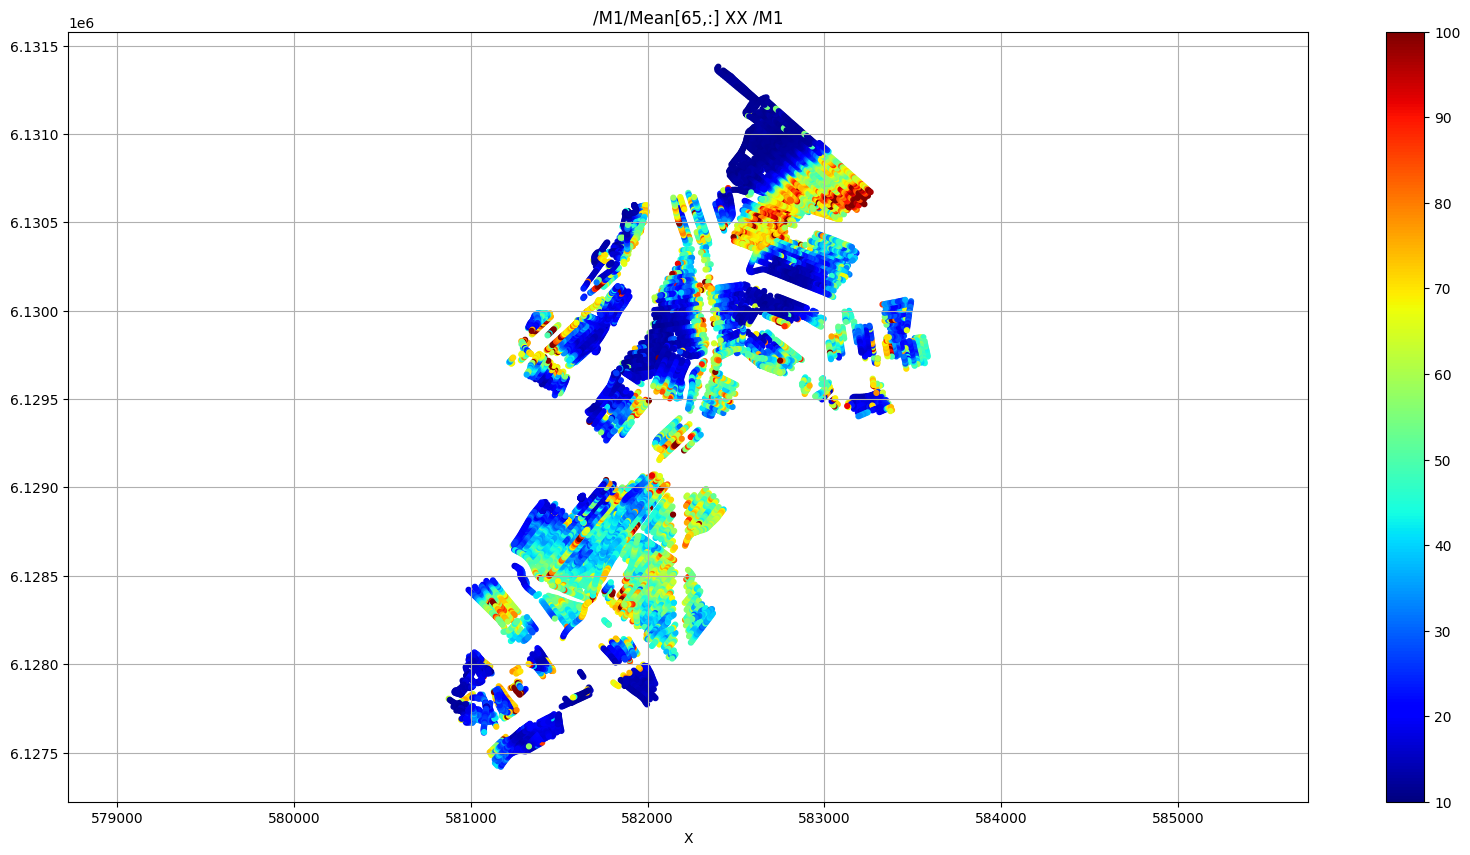

Plotting Feature 70 from /M1/Mean
(12118,)


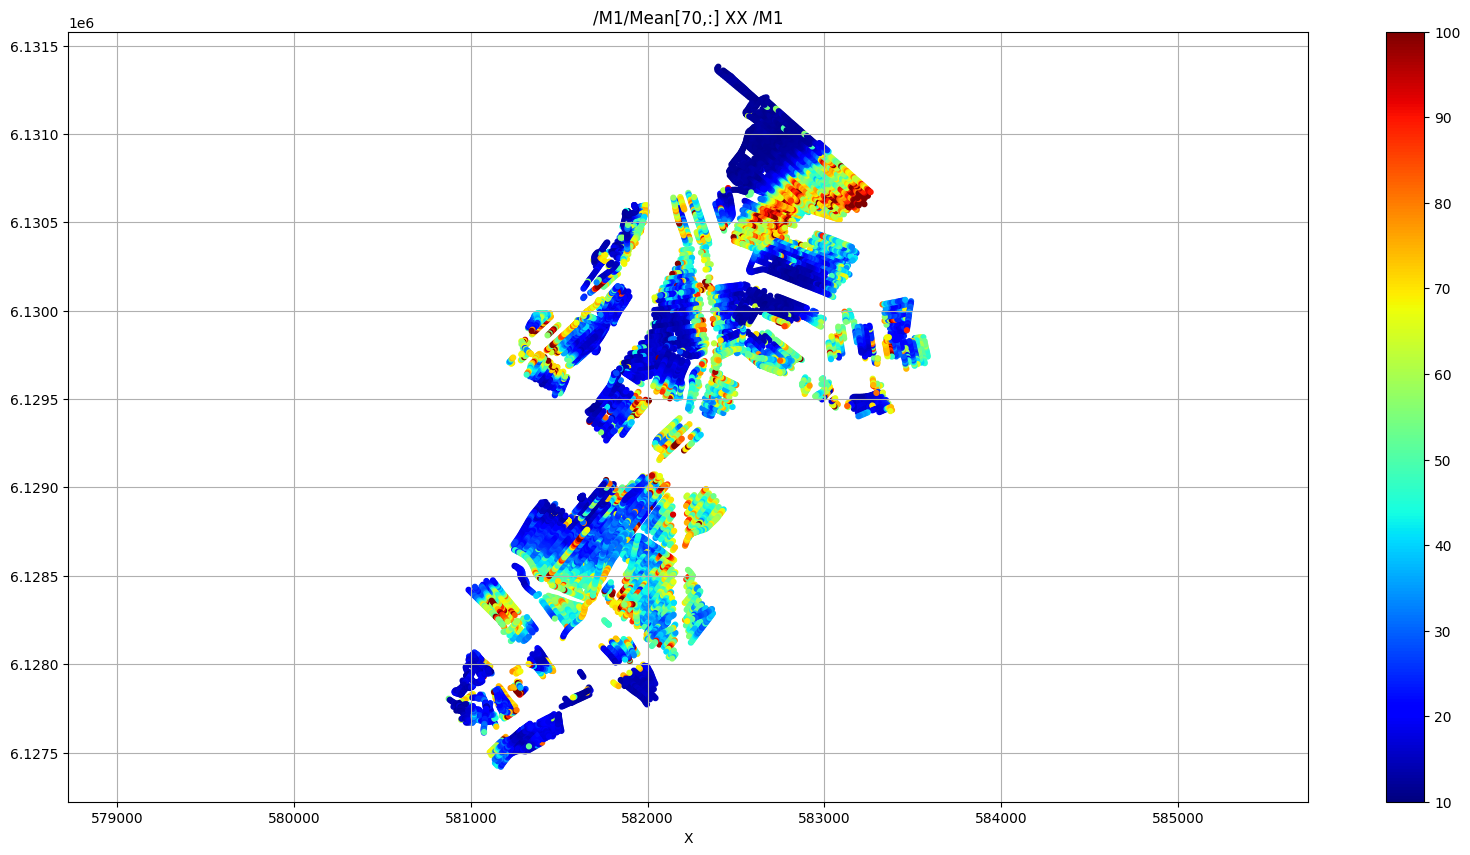

Plotting Feature 75 from /M1/Mean
(12118,)


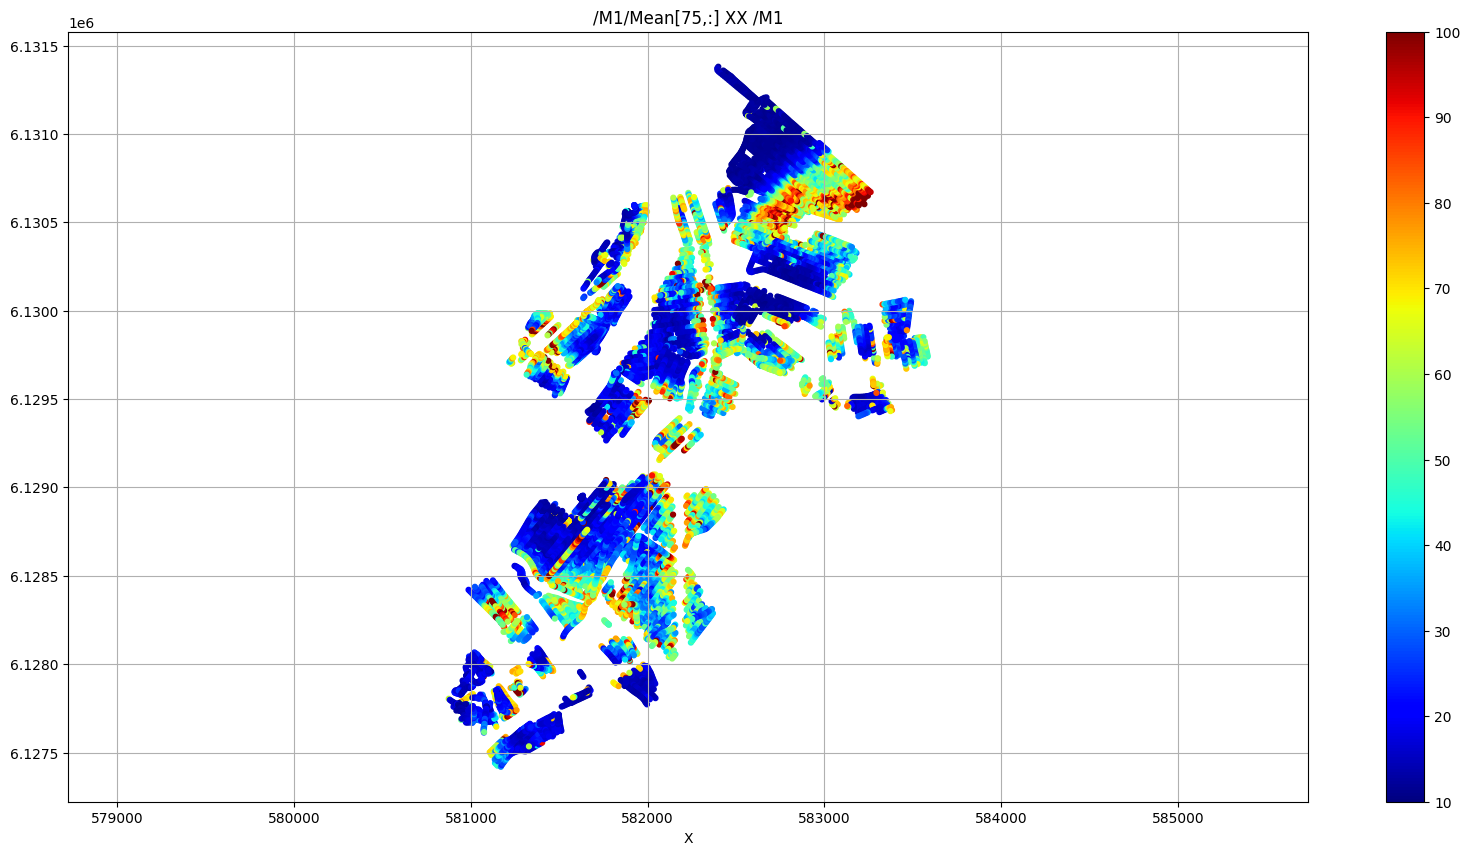

Plotting Feature 80 from /M1/Mean
(12118,)


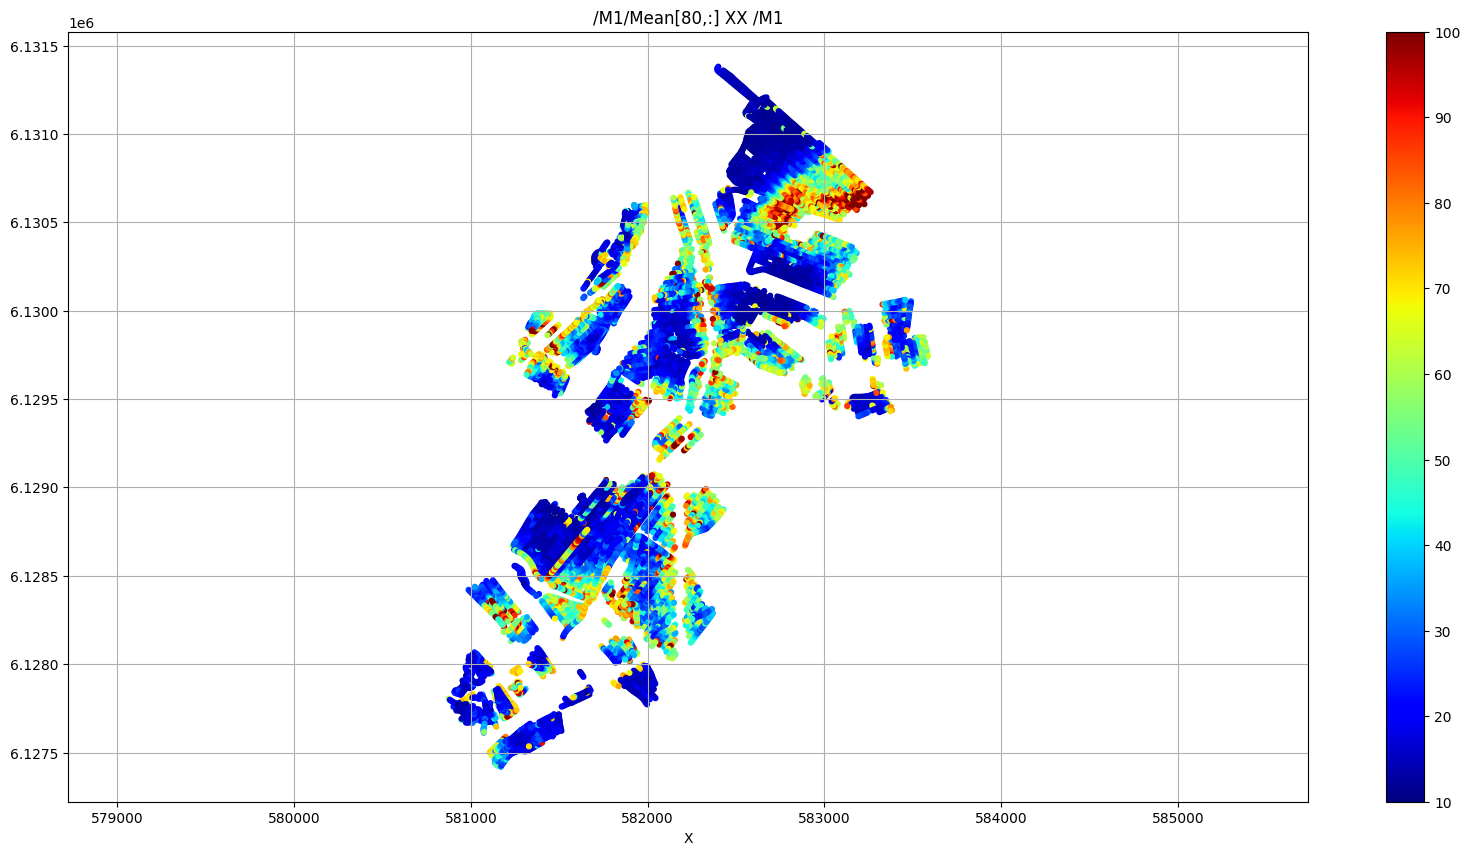

Plotting Feature 85 from /M1/Mean
(12118,)


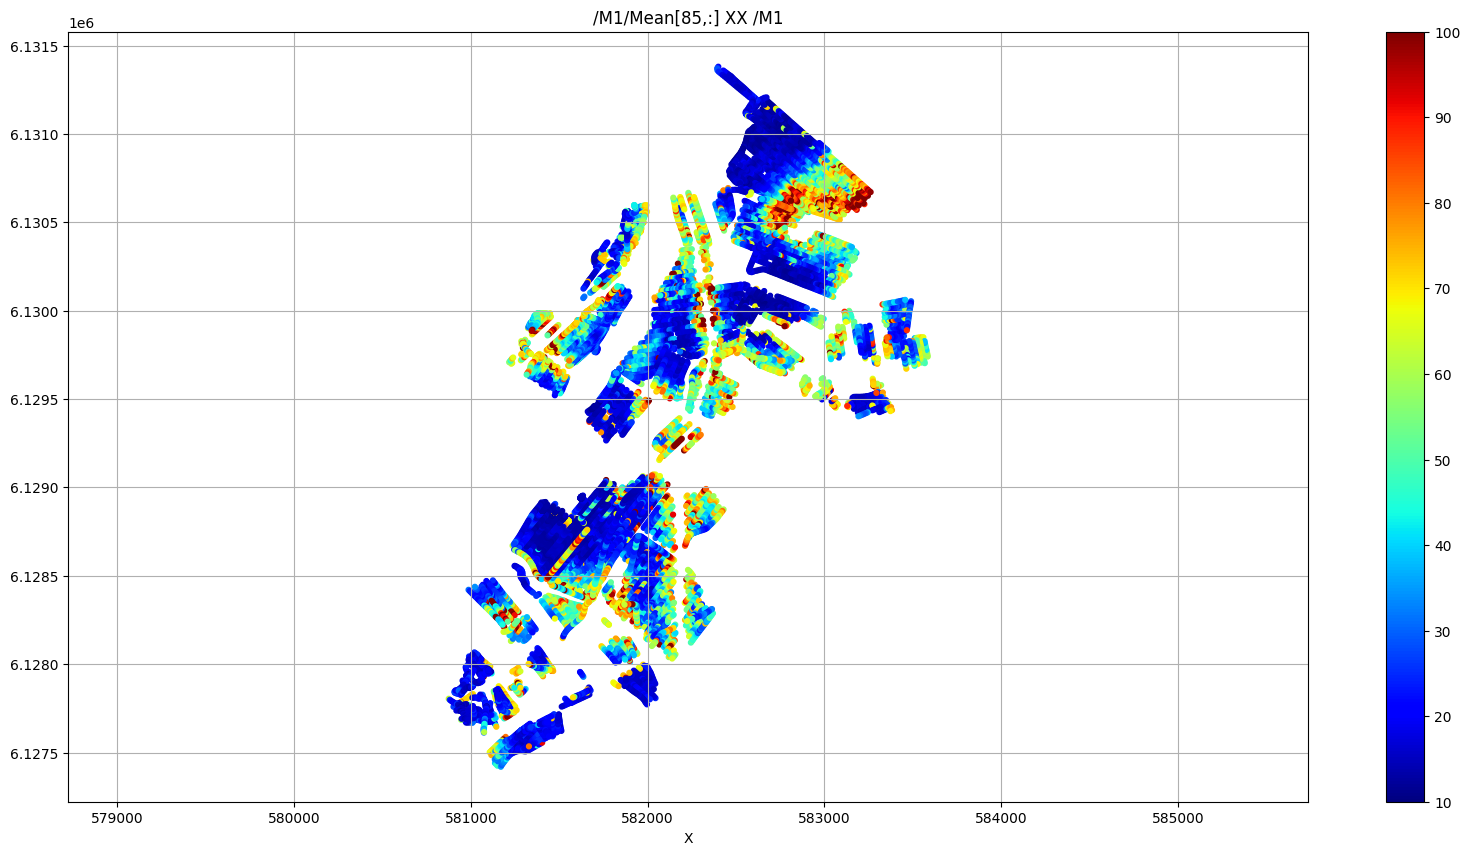

In [12]:
for iz in range(0,z_max,5):
    ig.plot_feature_2d(f_post_h5,im=1,iz=iz,key='Mean', title_text = 'XX', cmap='jet', s=12, vmin=10, vmax=100, hardcopy=hardcopy)

In [13]:
ig.post_to_csv(f_post_h5)

Writing to POST_FANGEL_AVG_PRIOR_UNIFORM_NL_4-4_log-uniform_N100000_TX07_20230828_2x4_RC20-33_Nh280_Nf12_Nu100000_aT1_M1.csv
Creating point data set: Median
- saving to : POST_FANGEL_AVG_PRIOR_UNIFORM_NL_4-4_log-uniform_N100000_TX07_20230828_2x4_RC20-33_Nh280_Nf12_Nu100000_aT1_M1_Median.csv
Creating point data set: Mean
- saving to : POST_FANGEL_AVG_PRIOR_UNIFORM_NL_4-4_log-uniform_N100000_TX07_20230828_2x4_RC20-33_Nh280_Nf12_Nu100000_aT1_M1_Mean.csv
Creating point data set: Std
- saving to : POST_FANGEL_AVG_PRIOR_UNIFORM_NL_4-4_log-uniform_N100000_TX07_20230828_2x4_RC20-33_Nh280_Nf12_Nu100000_aT1_M1_Std.csv


'POST_FANGEL_AVG_PRIOR_UNIFORM_NL_4-4_log-uniform_N100000_TX07_20230828_2x4_RC20-33_Nh280_Nf12_Nu100000_aT1_M1.csv'